## Import Neccessary Modules

In [1]:
import math
import random
import os
import shutil
import hashlib
from time import time
from operator import itemgetter
from collections import defaultdict
from scipy.stats import randint
from scipy import interp

import pickle
import subprocess
#import pe_features
#import pefile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
#from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
#from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

from sklearn import metrics
from sklearn import preprocessing
from sklearn import cross_validation
#from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.learning_curve import learning_curve
#from sklearn.grid_search import RandomizedSearchCV
from sklearn.grid_search import GridSearchCV

from sklearn.externals import joblib
from sklearn.utils import shuffle
#plt.rcParams['font.size'] = 18.0
#plt.rcParams['figure.figsize'] = 16.0, 5.0
%matplotlib inline
# import pymongo to connect to the mongdb
from pymongo import MongoClient
client = MongoClient('127.0.0.1', 27017)
db0m = client.cuckoo0m.analysis
db1m = client.cuckoo1m.analysis
db2m = client.cuckoo2m.analysis
db3m = client.cuckoo3m.analysis

print "Import Database OK!"

Import Database OK!


## Utility function to extract the type1 feature vector

In [2]:
# this function return the type1 feature vector which are all counts of certain behaviors
# see the Model.md for details
def load_one_profile_type1(report):
    
    features_attr = [
        "duration","dropped","tcp","udp","dns","http","hosts","domains","file_opened",
        "file_read","file_written","file_copied","file_exists","file_deleted",
        "directory_created","directory_enumerated","regkey_opened","regkey_read",
        "regkey_written","regkey_deleted","dll_loaded","processes","apistats",
        "guid","mutex"
    ]
    
    if not report:
        return None
    
    feature_list = {}
    
    feature_not_found_flag = -1
    feature_default_value = 0
    
    for feature in features_attr:
        feature_list[feature] = feature_not_found_flag
    
    #if "id" in report["info"]:
    #    print "Task id: %d" % report["info"]["id"]
    
    feature_list["duration"] = report["info"]["duration"]
    
    # count of the numbers of droped files.
    if "dropped" in report:
        feature_list["dropped"] = len(report["dropped"])
    else:
        feature_list["dropped"] = 0
    
    # count of network activities
    network_prots = ["tcp","udp","dns","http","hosts","domains"]
    for protocol in network_prots:
        if protocol in report["network"]:
            feature_list[protocol] = len(report["network"][protocol])
        
    # count of file activities, dll_loaded
    file_operations = ["file_opened","file_read","file_written","file_copied","file_exists",
                       "file_deleted","directory_created","directory_enumerated",
                       "regkey_opened","regkey_read","regkey_written","regkey_deleted",
                       "dll_loaded"]
    
    for fs_op in file_operations:
        if "behavior" in report and "summary" in report["behavior"] and fs_op in report["behavior"]["summary"]:
            feature_list[fs_op] = len(report["behavior"]["summary"][fs_op])
        else:
            feature_list[fs_op] = 0 # non-exist behavior operation.
    
    # count of total traced processes
    if "behavior" in report and "processes" in report["behavior"]:
        feature_list["processes"] = len(report["behavior"]["processes"])
    
    # count of total counts of apis
    if "behavior" in report and "apistats" in report["behavior"]:
        apistats = report["behavior"]["apistats"]
        num_apistats = 0
        for key in apistats:
            for k in apistats[key]:
                num_apistats += apistats[key][k]
    
        feature_list["apistats"] = num_apistats
    
    # guid and mutex
    if "behavior" in report and "summary" in report["behavior"] and "guid" in report["behavior"]["summary"]:
        feature_list["guid"] = len(report["behavior"]["summary"]["guid"])
    
    if "behavior" in report and "summary" in report["behavior"] and "mutex" in report["behavior"]["summary"]:
        feature_list["mutex"] = len(report["behavior"]["summary"]["mutex"])
    
    # set default value for the not find feature attributes 
    for f in feature_list:
        if (feature_list[f] == feature_not_found_flag):
            feature_list[f] == feature_default_value
            
    return feature_list

## Utility function that list file by size

In [3]:
def get_file_list_by_size(dirname, reverse=False):
    """ Return list of file paths in directory sorted by file size """

    # Get list of files
    filepaths = []
    for basename in os.listdir(dirname):
        filename = os.path.join(dirname, basename)
        if os.path.isfile(filename):
            filepaths.append(filename)

    # Re-populate list with filename, size tuples
    for i in xrange(len(filepaths)):
        filepaths[i] = (filepaths[i], os.path.getsize(filepaths[i]))

    # Sort list by file size
    # If reverse=True sort from largest to smallest
    # If reverse=False sort from smallest to largest
    filepaths.sort(key=lambda filename: filename[1], reverse=reverse)

    # Re-populate list with just filenames
    for i in xrange(len(filepaths)):
        filepaths[i] = filepaths[i][0]
        

    return filepaths

## Utility function that calculate sha256

In [4]:
FILE_CHUNK_SIZE = 16 * 1024
def get_chunks(file_path):
    """Read file contents in chuncks (generator)."""
    with open(file_path, "rb") as fd:
        while True:
            chunk = fd.read(FILE_CHUNK_SIZE)
            if not chunk:
                break
            yield chunk

def get_sha256(file_path):
    sha256 = hashlib.sha256()
    
    for chunk in get_chunks(file_path):
        sha256.update(chunk)
        
    return sha256.hexdigest()

## Utility function to load all profile by calling load one

In [5]:
# take a file list and load all the type 1 features from database and 
# return a two dimensional vector

def load_all_profile_type1(file_list, db):
    dataset = []
    for filepath in file_list:
        # get the sha256 in case the file name isn't
        
        path, name = os.path.split(filepath)
        if len(name) != 64:
            name = get_sha256(filepath)
                
        filehash = name
        #print "Debug: \"%s\"" % filehash
        report = db.find_one({"target.file.sha256" : filehash})
        if report:
            feature_vect = load_one_profile_type1(report)
            feature_vect['filename'] = filepath
            dataset.append(feature_vect)
            #print "Loaded profile: \"%s\"" % filehash
        else:
            #print "No profile found: \"%s\"" % filehash
            pass
        
    return dataset

## Utility function that load feature as Panda DataFrame

In [6]:
# Function that will return a panda dataframe
def load_dataframe(file_list, good_bad, db, t):
    # if .csv file exist, read features from .csv file
    csv_name = good_bad + "_" + t + ".csv"
    if os.path.exists(csv_name):
        df = pd.read_csv(csv_name)
        print "load_dataframe: loaded %d samples from \"%s\"" % (len(df.index), csv_name)
    # if .csv file doesn't exist, extract from file and save .csv
    else:
        df = pd.DataFrame.from_records(load_all_profile_type1(file_list, db))
        cols = df.columns.tolist()
        cols.insert(0, cols.pop(cols.index('filename')))
        df = df.reindex(columns=cols)
        df['label'] = good_bad
        print "load_dataframe: loaded %d samples from database" % len(df.index)
        df.to_csv(csv_name, index=False)
        print "load_dataframe: saved %d samples to \"%s\"" % (len(df.index), csv_name)
        
    return df

## Input Data for classic and UCB1

In [7]:
clf0 = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)
clf1 = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=16,
            min_samples_split=4, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')
clf2 = GradientBoostingClassifier(init=None, learning_rate=1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
clf3 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

clfs = [clf0, clf1, clf2, clf3]
db_clf_tuples = [(db0m, clf0), (db1m, clf1), (db2m, clf2), (db3m, clf3)]

## Define a Data_Analysis class 

In [8]:
class Data_Analysis:
    def __init__(self, db, clf, random=111, A=1, beta=0.01, k=0.5):
        self.bad_file_path = "/Volumes/SST3/Samples/ml_test_set_all_1315/"
        self.good_file_path = "/Volumes/SST3/Samples/gd_test_set_all_630/"
        self.bad_file_list = [os.path.join(self.bad_file_path, child) for child in os.listdir(self.bad_file_path) \
                              if child.find('._') == -1]
        self.good_file_list = [os.path.join(self.good_file_path, child) for child in os.listdir(self.good_file_path)\
                               if child.find('._') == -1]
        self.db = db
        self.clf = clf
        self.random =  random
        self.A = A
        self.beta = beta
        self.k = 0.5 if k == 0 else k
        #return values
        self.X_test = []
        self.y_test = []
        self.y_pred = []
        self.rewards = []
        self.sum_rewards = 0
        
    def reward(self, y_test, y_pred): #normalized the reward to [0, 1]
        for i in range(len(y_pred)):
            accuracy = accuracy_score(y_test[0:i+1], y_pred[0:i+1])
            reward = self.A * (accuracy - self.beta * self.k)
            normalize = (reward + 3. * self.beta) / (1 + 2.5 * self.beta)
            self.sum_rewards += normalize
            self.rewards.append(self.sum_rewards / (i+1))
            
    def reward_cal(self, y_pred, y_test):
        for i in range(len(y_pred)):
            accuracy = accuracy_score(y_test[0:i+1], y_pred[0:i+1])
            reward = self.A * (accuracy - self.beta * self.k)
            if reward < 0:
                reward = 0
            self.rewards.append(reward)
            
    def load_dataframe(self, file_list, good_bad, db, t):
        # if .csv file exist, read features from .csv file
        csv_name = good_bad + "_" + t + ".csv"
        if os.path.exists(csv_name):
            df = pd.read_csv(csv_name)
        else:
            df = pd.DataFrame.from_records(load_all_profile_type1(file_list, db))
            cols = df.columns.tolist()
            cols.insert(0, cols.pop(cols.index('filename')))
            df = df.reindex(columns=cols)
            df['label'] = good_bad
            df.to_csv(csv_name, index=False)
        
        return df            
    
    def dataframes_to_split_sets(self, df_bad, df_good, random):
        df = pd.concat([df_bad, df_good], ignore_index=True)
        df.replace(-1, 0, inplace=True)          # not found set to default -1 
        no_label = list(df.columns.values)
        no_label.remove('filename')
        no_label.remove('label')
        X = df.as_matrix(no_label)
        y = np.array(df['label'].tolist())
        #Xnorm = preprocessing.normalize(X)
        #ynorm = y

        # Binarize the label, convert the label from "bad = 0", "good = 1"
        lb = preprocessing.LabelBinarizer()
        y = lb.fit_transform(y).flatten()
        #print "30 seconds data frame generated."

        X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.5, random_state=random)

        return X_train, X_test, y_train, y_test        
        
    def Analysis(self, rand):
        df_bad = self.load_dataframe(self.bad_file_list, 'bad', self.db, str(int(self.k)))
        #df_bad.to_csv('df_bad_DataFrameRaw_' + str(int(self.k)) + '.csv', index=False)
        df_good = self.load_dataframe(self.good_file_list, 'good', self.db, str(int(self.k)))
        #df_good.to_csv('df_good_DataFrameRaw_' + str(int(self.k)) + '.csv', index=False)
        
        X_train, self.X_test, y_train, self.y_test = self.dataframes_to_split_sets(df_bad, df_good, self.random)
        self.X_test, self.y_test = shuffle(self.X_test, self.y_test, random_state=rand)
        self.clf.fit(X_train[:, np.arange(1, X_train.shape[1])], y_train)
        self.y_pred = self.clf.predict(self.X_test[:,np.arange(1, self.X_test.shape[1])])
        self.reward(self.y_test, self.y_pred)
    
    def get_test_data(self):
        return self.X_test, self.y_test
    
    def get_test_result(self):
        return self.y_pred, self.y_test
    
    def get_rewards(self):
        return self.rewards

## Define a UCB1 class for generate multiple rewards.

In [9]:
class UCB1:
    def __init__(self, y_preds, y_tests, numActions, A=1, beta=0.01, dbg=False):
        self.y_tests = y_tests
        self.y_preds = y_preds
        self.numAction = numActions
        self.A = A
        self.beta = beta
        self.dbg = dbg
        self.y_pred_ucb = [[], [], [], []]
        self.y_test_ucb = [[], [], [], []]
        self.ucb1_rewards = []
        self.total_cost = [0] * 4
        self.accuracy =[0] * 4
        
    def upperBound(self, step, numPlays):
        return math.sqrt(0.2 * math.log(step + 1) / numPlays)
    
    def reward01(self, k, t):
        pass
        
    def reward(self, k, t): # This reward function could be shared by both with and without contextual
        self.y_test_ucb[k].append(self.y_tests[k][t])
        self.y_pred_ucb[k].append(self.y_preds[k][t])
        self.accuracy[k] = accuracy_score(self.y_test_ucb[k], self.y_pred_ucb[k])
        if self.dbg:
            print "{0}: Accuracy={1}".format(t+1, self.accuracy[k])
            print "{0}: {1}".format(t+1, self.y_test_ucb[k])
            print "{0}: {1}".format(t+1, self.y_pred_ucb[k])
            
        reward = self.A * (self.accuracy[k] - self.beta * (0.5 if k == 0 else k))
        return (reward + 3. * self.beta) / (1 + 2.5 * self.beta)
    
    def ucb1(self, numActions, reward):
        payoffSums = [0] * numActions
        numPlays = [1] * numActions
        ucbs = [0] * numActions

        #initialize empirical sums
        for n in range(numActions):
            payoffSums[n] = reward(n, n)
            ucbs[n] = payoffSums[n]
            yield n, payoffSums[n], ucbs

        t = numActions

        while True:
            ucbs = [payoffSums[i] / numPlays[i] + self.upperBound(t, numPlays[i]) for i in range(numActions)]
            action = max(range(numActions), key = lambda i: ucbs[i])
            theReward = self.reward(action, t)
            numPlays[action] += 1
            payoffSums[action] += theReward

            yield action, theReward, ucbs
            t = t + 1
    
    def Testing(self):
        #numActions = 4
        self.ucb1_rewards = []
        numRounds = len(self.y_tests[0]) # 345 which is number of test samples

        cumulativeReward = 0
        total_time = 0
        positives = 0
        if self.dbg:
            print("========== debug UCB1 flag is turned on ==========")
        #t = self.numAction
        t = 1 #round counter
        for (choice, reward, ucbs) in self.ucb1(self.numAction, self.reward):
            cumulativeReward += reward
            total_time += choice
            if self.dbg:
                print("%d: choice: %d\treward: %f" % (t, choice, reward)), 
                print ucbs
            #self.ucb1_rewards.append(reward)
            self.ucb1_rewards.append(cumulativeReward / t)
            t += 1
            if t > numRounds:
                break
        #print('cumulativeReward: %f' % cumulativeReward)
        #print('total_time: %d' % total_time)

## Function generate the mean values for plot

In [10]:
def multi_rounds_testing(db_clf_tuples, A=1, beta=0.01, rounds=100, dbg=False):
    rand_states = np.random.randint(1000, size=rounds)
    #rand_states = [868]
    c_rewards_total = []
    ucb1_rewards_total = []
    print "Start the experiment... print the rand used to shuffle testing samples"
    for c, rand in enumerate(rand_states, start=1):
        X_tests = []
        y_tests = []
        y_preds = []
        c_rewards = []
        for i, db_clf_tuple in enumerate(db_clf_tuples):
            #print db_clf_tuple[0]
            #print db_clf_tuple[1]
            the_data = Data_Analysis(db_clf_tuple[0], db_clf_tuple[1], random=111, A=A, beta=beta, k=i)
            the_data.Analysis(rand)
            c_rewards.append(the_data.get_rewards())
            X_test, y_test = the_data.get_test_data()
            y_pred, y_test = the_data.get_test_result()
            X_tests.append(X_test)
            y_tests.append(y_test)
            y_preds.append(y_pred)

        if len(c_rewards_total) == 0:
            c_rewards_total = np.matrix(c_rewards)
        else:
            c_rewards_total = np.matrix(c_rewards_total) + np.matrix(c_rewards)

        UCB1_obj = UCB1(y_preds, y_tests, 4, A=A, beta=beta, dbg=dbg)
        UCB1_obj.Testing()
        ucb1_rewards = UCB1_obj.ucb1_rewards
        if len(ucb1_rewards_total) == 0:
            ucb1_rewards_total = ucb1_rewards
        else:
            ucb1_rewards_total = [a + b for a, b in zip(ucb1_rewards_total, ucb1_rewards)]
        if (c % 10 == 0):    
            print rand
        else:
            print rand,
    print "\nExperiments done!"
    c_rewards_mean = c_rewards_total / float(rounds)
    c_rewards_mean = c_rewards_mean.tolist()
    ucb1_rewards_mean = [x / float(rounds) for x in ucb1_rewards_total]
    
    return c_rewards_mean, ucb1_rewards_mean

## Testing Code

In [11]:
A = 1
beta = 0
rounds = 100
c_rewards_mean, ucb1_rewards_mean = multi_rounds_testing(db_clf_tuples, A=A, beta=beta, rounds=rounds,dbg=False)
plt.rcParams['figure.figsize'] = 12.0, 9.0
plt.rcParams.update({'font.size': 15})
xa = np.linspace(0, 973, num=973)
plt.plot(xa, c_rewards_mean[0], color='r', linewidth=2, label="30 Seconds")
plt.plot(xa, c_rewards_mean[1], color='y', linewidth=2, label="1 Minutes")
plt.plot(xa, c_rewards_mean[2], color='b', linewidth=2, label="2 Minutes")
plt.plot(xa, c_rewards_mean[3], color='c', linewidth=2, label="3 Minutes")
plt.plot(xa, ucb1_rewards_mean, color='g', linewidth=2, label="UCB1")
#plt.ylim([0.4,1])
plt.title("Reward comparison for A = {0}, $\\beta$ = {1}, rounds = {2}".format(A, beta, rounds))
plt.xlabel("sequence of samples")
plt.ylabel("Reward = A*accuracy - $\\beta$ * cost")
plt.grid()
plt.legend(loc=4)
plt.savefig('Rewards_beta_{0}_{1}.pdf'.format(beta,rounds))

Start the experiment... print the rand used to shuffle testing samples
275 434 967 917 698 230 387 597 97 202
505 884 609 750 170 597 361 336 543 349
733 63 685 703 515 646 621 747 22 286
374 445 293 176 962 131 239 4 207 747
626 336 393 991 694 257 711 962 918 440
112 859 924 329 170 30 861 837 958 451
817 423 990 472 402 965 605 244 145 538
527 334 859 88 533 591 61 724 773 657
881 955 249 598 132 88 23 124 48 833
772 488 418 998 205 128 207 748 141 187

Experiments done!


Start the experiment... print the rand used to shuffle testing samples
502 740 566 781 986 383 830 526 969 55
103 763 861 480 201 183 609 41 866 692
633 368 599 549 177 256 216 799 264 818
912 614 84 332 758 938 937 923 867 879
928 417 173 272 450 350 207 478 192 69
239 421 710 466 283 489 119 54 855 804
993 498 209 738 395 794 566 571 685 685
123 856 564 49 323 136 735 487 514 460
849 943 968 54 208 878 134 967 780 849
109 118 668 633 421 455 443 770 193 738

Experiments done!


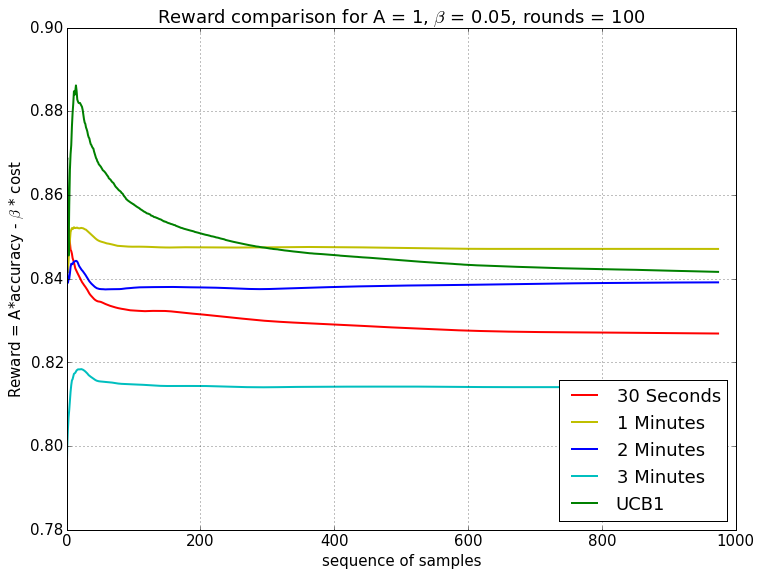

In [12]:
A = 1
beta = 0.05
rounds = 100
c_rewards_mean, ucb1_rewards_mean = multi_rounds_testing(db_clf_tuples, A=A, beta=beta, rounds=rounds,dbg=False)
plt.rcParams['figure.figsize'] = 12.0, 9.0
plt.rcParams.update({'font.size': 15})
xa = np.linspace(0, 973, num=973)
plt.plot(xa, c_rewards_mean[0], color='r', linewidth=2, label="30 Seconds")
plt.plot(xa, c_rewards_mean[1], color='y', linewidth=2, label="1 Minutes")
plt.plot(xa, c_rewards_mean[2], color='b', linewidth=2, label="2 Minutes")
plt.plot(xa, c_rewards_mean[3], color='c', linewidth=2, label="3 Minutes")
plt.plot(xa, ucb1_rewards_mean, color='g', linewidth=2, label="UCB1")
#plt.ylim([0.4,1])
plt.title("Reward comparison for A = {0}, $\\beta$ = {1}, rounds = {2}".format(A, beta, rounds))
plt.xlabel("sequence of samples")
plt.ylabel("Reward = A*accuracy - $\\beta$ * cost")
plt.grid()
plt.legend(loc=4)
plt.savefig('Rewards_beta_{0}_{1}.pdf'.format(beta,rounds))

Start the experiment... print the rand used to shuffle testing samples
16 271 954 805 491 322 842 293 118 407
448 726 457 317 71 889 965 526 979 154
401 891 31 659 757 2 985 598 879 562
999 158 97 751 254 51 110 886 363 326
515 420 553 428 130 37 997 558 166 451
580 532 577 955 586 857 502 34 677 329
615 149 519 608 50 258 42 58 201 350
570 333 581 321 601 616 285 962 174 783
49 614 617 984 316 547 724 734 567 6
332 712 624 230 368 170 506 656 630 417

Experiments done!


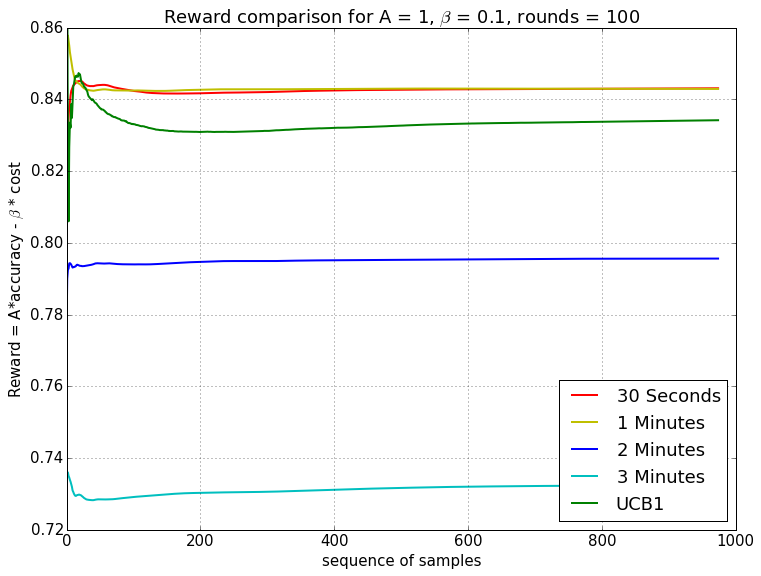

In [13]:
A = 1
beta = 0.1
rounds = 100
c_rewards_mean, ucb1_rewards_mean = multi_rounds_testing(db_clf_tuples, A=A, beta=beta, rounds=rounds,dbg=False)
plt.rcParams['figure.figsize'] = 12.0, 9.0
plt.rcParams.update({'font.size': 15})
xa = np.linspace(0, 973, num=973)
plt.plot(xa, c_rewards_mean[0], color='r', linewidth=2, label="30 Seconds")
plt.plot(xa, c_rewards_mean[1], color='y', linewidth=2, label="1 Minutes")
plt.plot(xa, c_rewards_mean[2], color='b', linewidth=2, label="2 Minutes")
plt.plot(xa, c_rewards_mean[3], color='c', linewidth=2, label="3 Minutes")
plt.plot(xa, ucb1_rewards_mean, color='g', linewidth=2, label="UCB1")
#plt.ylim([0.4,1])
plt.title("Reward comparison for A = {0}, $\\beta$ = {1}, rounds = {2}".format(A, beta, rounds))
plt.xlabel("sequence of samples")
plt.ylabel("Reward = A*accuracy - $\\beta$ * cost")
plt.grid()
plt.legend(loc=4)
plt.savefig('Rewards_beta_{0}_{1}.pdf'.format(beta,rounds))

Start the experiment... print the rand used to shuffle testing samples
793 500 603 413 665 310 938 586 811 59
54 145 627 107 809 459 938 177 442 293
139 321 778 755 500 315 58 249 401 433
842 817 968 4 479 344 893 116 899 28
345 256 327 844 605 236 171 889 182 79
48 779 883 857 642 820 385 773 173 55
916 614 712 191 955 951 973 466 68 731
622 294 595 420 364 968 221 891 250 287
118 902 887 749 798 157 922 102 254 208
153 356 388 101 468 798 245 764 588 597

Experiments done!


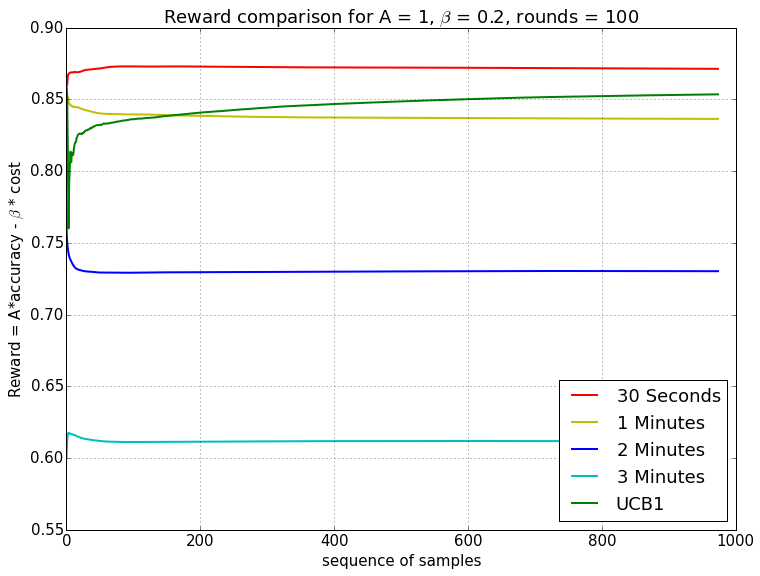

In [14]:
A = 1
beta = 0.2
rounds = 100
c_rewards_mean, ucb1_rewards_mean = multi_rounds_testing(db_clf_tuples, A=A, beta=beta, rounds=rounds,dbg=False)
plt.rcParams['figure.figsize'] = 12.0, 9.0
plt.rcParams.update({'font.size': 15})
xa = np.linspace(0, 973, num=973)
plt.plot(xa, c_rewards_mean[0], color='r', linewidth=2, label="30 Seconds")
plt.plot(xa, c_rewards_mean[1], color='y', linewidth=2, label="1 Minutes")
plt.plot(xa, c_rewards_mean[2], color='b', linewidth=2, label="2 Minutes")
plt.plot(xa, c_rewards_mean[3], color='c', linewidth=2, label="3 Minutes")
plt.plot(xa, ucb1_rewards_mean, color='g', linewidth=2, label="UCB1")
#plt.ylim([0.4,1])
plt.title("Reward comparison for A = {0}, $\\beta$ = {1}, rounds = {2}".format(A, beta, rounds))
plt.xlabel("sequence of samples")
plt.ylabel("Reward = A*accuracy - $\\beta$ * cost")
plt.grid()
plt.legend(loc=4)
plt.savefig('Rewards_beta_{0}_{1}.pdf'.format(beta,rounds))

Start the experiment... print the rand used to shuffle testing samples
607 222 922 783 553 738 667 807 723 264
324 971 137 330 531 972 197 569 400 523
623 985 152 977 16 855 301 840 699 275
433 248 951 961 298 973 269 568 932 627
85 441 500 600 712 606 73 619 154 272
310 506 150 968 528 374 986 654 80 158
918 652 851 819 766 580 923 53 132 206
824 766 770 822 576 48 221 589 163 57
263 515 506 934 972 716 374 795 645 9
781 239 138 812 314 332 11 737 598 158

Experiments done!


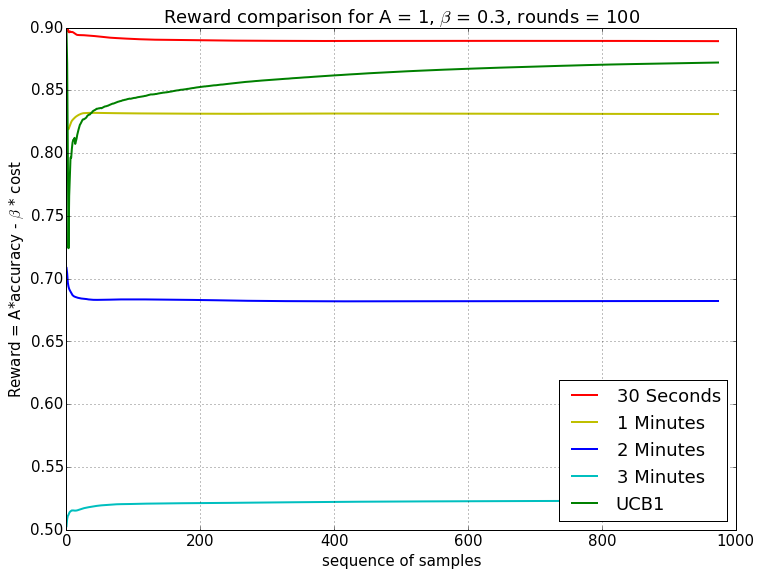

In [15]:
A = 1
beta = 0.3
rounds = 100
c_rewards_mean, ucb1_rewards_mean = multi_rounds_testing(db_clf_tuples, A=A, beta=beta, rounds=rounds,dbg=False)
plt.rcParams['figure.figsize'] = 12.0, 9.0
plt.rcParams.update({'font.size': 15})
xa = np.linspace(0, 973, num=973)
plt.plot(xa, c_rewards_mean[0], color='r', linewidth=2, label="30 Seconds")
plt.plot(xa, c_rewards_mean[1], color='y', linewidth=2, label="1 Minutes")
plt.plot(xa, c_rewards_mean[2], color='b', linewidth=2, label="2 Minutes")
plt.plot(xa, c_rewards_mean[3], color='c', linewidth=2, label="3 Minutes")
plt.plot(xa, ucb1_rewards_mean, color='g', linewidth=2, label="UCB1")
#plt.ylim([0.4,1])
plt.title("Reward comparison for A = {0}, $\\beta$ = {1}, rounds = {2}".format(A, beta, rounds))
plt.xlabel("sequence of samples")
plt.ylabel("Reward = A*accuracy - $\\beta$ * cost")
plt.grid()
plt.legend(loc=4)
plt.savefig('Rewards_beta_{0}_{1}.pdf'.format(beta,rounds))

Start the experiment... print the rand used to shuffle testing samples
849 741 183 568 997 337 382 246 250 724
983 198 994 99 10 530 591 41 251 206
769 74 696 363 751 168 131 861 367 14
156 200 31 256 486 128 557 259 255 251
216 350 708 638 454 997 474 355 266 565
910 536 66 968 886 955 678 427 275 904
279 100 186 148 487 675 537 745 349 963
539 924 361 205 986 669 704 861 757 159
66 665 459 139 443 653 571 203 640 640
992 584 964 763 577 141 547 547 297 622

Experiments done!


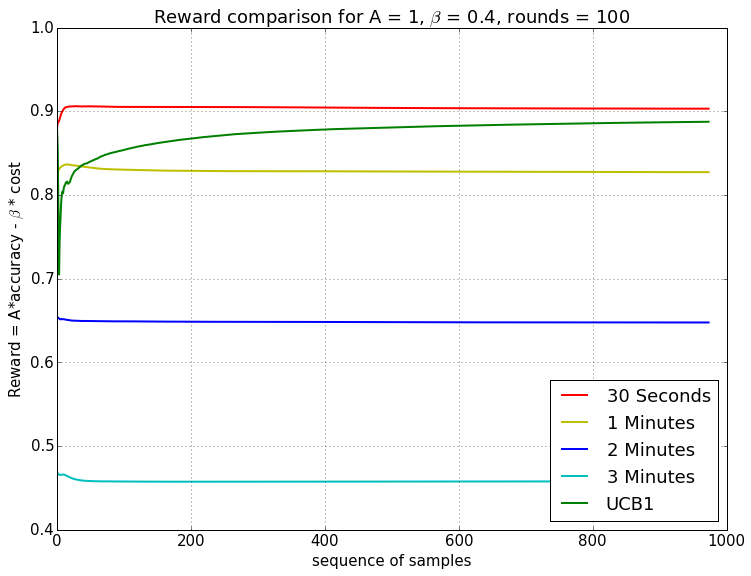

In [16]:
A = 1
beta = 0.4
rounds = 100
c_rewards_mean, ucb1_rewards_mean = multi_rounds_testing(db_clf_tuples, A=A, beta=beta, rounds=rounds,dbg=False)
plt.rcParams['figure.figsize'] = 12.0, 9.0
plt.rcParams.update({'font.size': 15})
xa = np.linspace(0, 973, num=973)
plt.plot(xa, c_rewards_mean[0], color='r', linewidth=2, label="30 Seconds")
plt.plot(xa, c_rewards_mean[1], color='y', linewidth=2, label="1 Minutes")
plt.plot(xa, c_rewards_mean[2], color='b', linewidth=2, label="2 Minutes")
plt.plot(xa, c_rewards_mean[3], color='c', linewidth=2, label="3 Minutes")
plt.plot(xa, ucb1_rewards_mean, color='g', linewidth=2, label="UCB1")
#plt.ylim([0.4,1])
plt.title("Reward comparison for A = {0}, $\\beta$ = {1}, rounds = {2}".format(A, beta, rounds))
plt.xlabel("sequence of samples")
plt.ylabel("Reward = A*accuracy - $\\beta$ * cost")
plt.grid()
plt.legend(loc=4)
plt.savefig('Rewards_beta_{0}_{1}.pdf'.format(beta,rounds))

Start the experiment... print the rand used to shuffle testing samples
337 931 691 794 881 389 523 684 111 44
553 252 421 730 188 682 174 492 178 971
880 234 104 943 531 682 897 824 101 366
541 775 262 534 290 679 412 796 503 326
250 834 254 357 858 887 913 665 342 367
894 35 959 600 453 200 130 941 570 985
914 539 539 964 158 639 145 110 945 897
442 509 10 926 465 717 458 498 923 476
206 817 556 501 822 634 994 7 831 978
405 930 78 862 573 384 598 576 637 905

Experiments done!


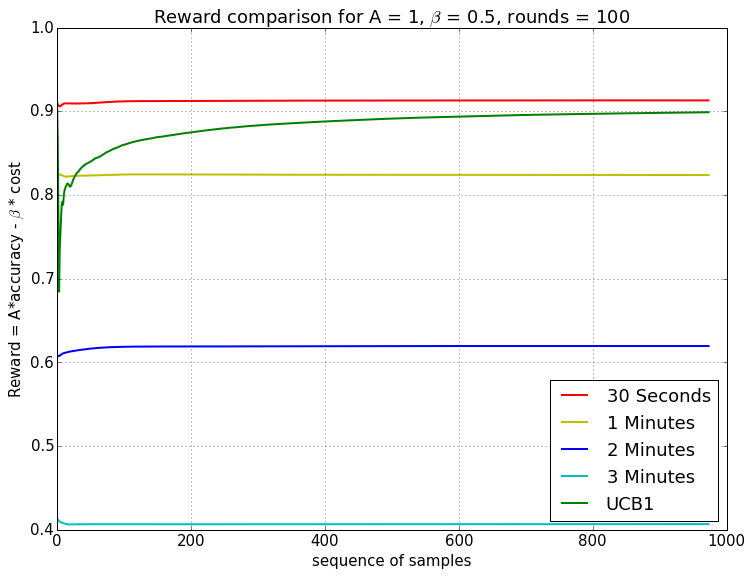

In [17]:
A = 1
beta = 0.5
rounds = 100
c_rewards_mean, ucb1_rewards_mean = multi_rounds_testing(db_clf_tuples, A=A, beta=beta, rounds=rounds,dbg=False)
plt.rcParams['figure.figsize'] = 12.0, 9.0
plt.rcParams.update({'font.size': 15})
xa = np.linspace(0, 973, num=973)
plt.plot(xa, c_rewards_mean[0], color='r', linewidth=2, label="30 Seconds")
plt.plot(xa, c_rewards_mean[1], color='y', linewidth=2, label="1 Minutes")
plt.plot(xa, c_rewards_mean[2], color='b', linewidth=2, label="2 Minutes")
plt.plot(xa, c_rewards_mean[3], color='c', linewidth=2, label="3 Minutes")
plt.plot(xa, ucb1_rewards_mean, color='g', linewidth=2, label="UCB1")
#plt.ylim([0.4,1])
plt.title("Reward comparison for A = {0}, $\\beta$ = {1}, rounds = {2}".format(A, beta, rounds))
plt.xlabel("sequence of samples")
plt.ylabel("Reward = A*accuracy - $\\beta$ * cost")
plt.grid()
plt.legend(loc=4)
plt.savefig('Rewards_beta_{0}_{1}.pdf'.format(beta,rounds))

Start the experiment... print the rand used to shuffle testing samples
936 93 316 510 889 303 439 411 729 322
224 172 904 376 667 565 938 29 987 254
761 124 626 689 447 386 278 20 127 369
253 818 862 248 943 998 195 460 290 362
26 906 429 850 382 143 282 652 70 725
317 186 688 422 987 440 676 813 683 37
60 670 808 885 65 674 932 257 79 628
341 79 512 862 777 188 109 708 797 403
484 914 610 60 157 845 528 366 925 137
524 55 222 436 76 632 851 809 257 28

Experiments done!


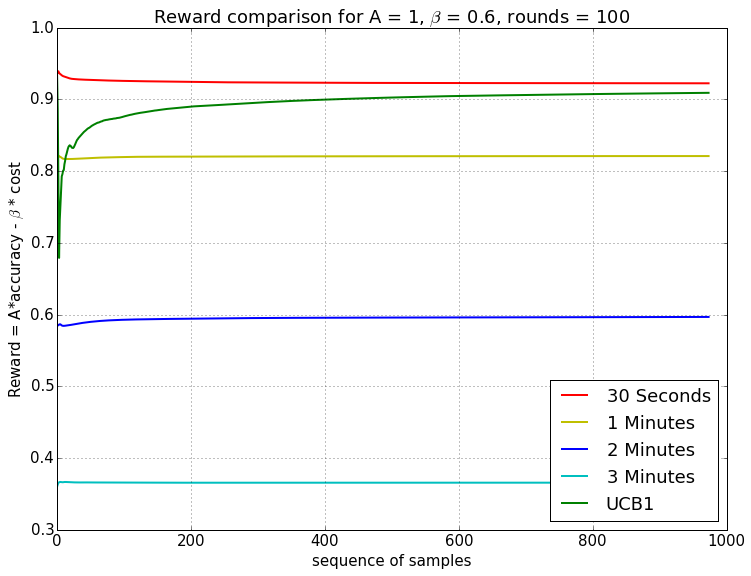

In [18]:
A = 1
beta = 0.6
rounds = 100
c_rewards_mean, ucb1_rewards_mean = multi_rounds_testing(db_clf_tuples, A=A, beta=beta, rounds=rounds,dbg=False)
plt.rcParams['figure.figsize'] = 12.0, 9.0
plt.rcParams.update({'font.size': 15})
xa = np.linspace(0, 973, num=973)
plt.plot(xa, c_rewards_mean[0], color='r', linewidth=2, label="30 Seconds")
plt.plot(xa, c_rewards_mean[1], color='y', linewidth=2, label="1 Minutes")
plt.plot(xa, c_rewards_mean[2], color='b', linewidth=2, label="2 Minutes")
plt.plot(xa, c_rewards_mean[3], color='c', linewidth=2, label="3 Minutes")
plt.plot(xa, ucb1_rewards_mean, color='g', linewidth=2, label="UCB1")
#plt.ylim([0.4,1])
plt.title("Reward comparison for A = {0}, $\\beta$ = {1}, rounds = {2}".format(A, beta, rounds))
plt.xlabel("sequence of samples")
plt.ylabel("Reward = A*accuracy - $\\beta$ * cost")
plt.grid()
plt.legend(loc=4)
plt.savefig('Rewards_beta_{0}_{1}.pdf'.format(beta,rounds))

Start the experiment... print the rand used to shuffle testing samples
744 189 287 503 996 184 527 59 127 103
26 681 879 611 562 597 810 371 110 732
73 609 414 306 25 226 619 373 520 564
709 365 697 268 911 93 783 885 437 786
135 561 621 12 729 3 827 482 917 228
429 477 534 914 291 278 38 152 235 69
503 361 273 377 804 926 59 992 202 690
636 794 379 954 915 662 72 876 613 929
560 473 267 889 670 105 855 30 219 463
900 596 67 505 234 980 339 294 5 144

Experiments done!


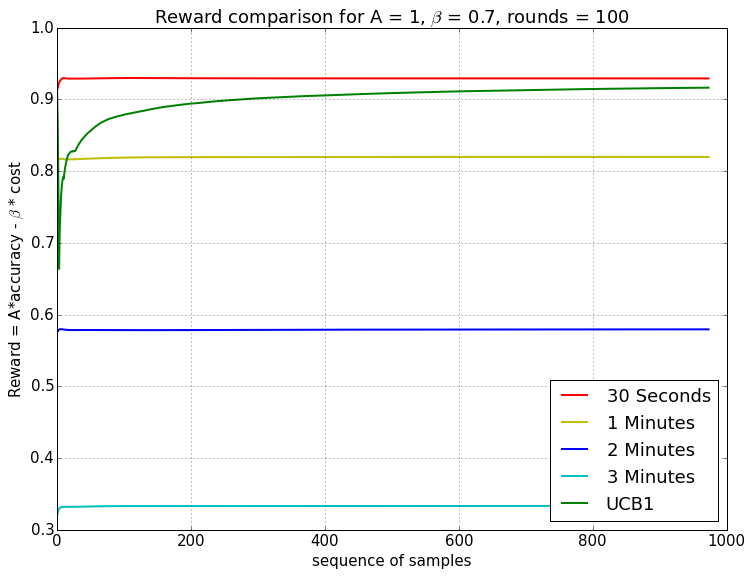

In [19]:
A = 1
beta = 0.7
rounds = 100
c_rewards_mean, ucb1_rewards_mean = multi_rounds_testing(db_clf_tuples, A=A, beta=beta, rounds=rounds,dbg=False)
plt.rcParams['figure.figsize'] = 12.0, 9.0
plt.rcParams.update({'font.size': 15})
xa = np.linspace(0, 973, num=973)
plt.plot(xa, c_rewards_mean[0], color='r', linewidth=2, label="30 Seconds")
plt.plot(xa, c_rewards_mean[1], color='y', linewidth=2, label="1 Minutes")
plt.plot(xa, c_rewards_mean[2], color='b', linewidth=2, label="2 Minutes")
plt.plot(xa, c_rewards_mean[3], color='c', linewidth=2, label="3 Minutes")
plt.plot(xa, ucb1_rewards_mean, color='g', linewidth=2, label="UCB1")
#plt.ylim([0.4,1])
plt.title("Reward comparison for A = {0}, $\\beta$ = {1}, rounds = {2}".format(A, beta, rounds))
plt.xlabel("sequence of samples")
plt.ylabel("Reward = A*accuracy - $\\beta$ * cost")
plt.grid()
plt.legend(loc=4)
plt.savefig('Rewards_beta_{0}_{1}.pdf'.format(beta,rounds))

Start the experiment... print the rand used to shuffle testing samples
64 559 63 131 506 620 193 397 361 982
35 564 135 694 803 413 761 444 115 375
48 247 696 522 400 927 585 246 426 425
514 778 236 842 840 236 311 62 69 177
410 284 256 104 708 904 905 792 65 524
17 978 877 677 365 892 570 480 228 661
349 756 968 781 489 219 412 740 550 557
203 144 231 956 213 942 913 43 268 987
733 44 854 399 21 39 74 598 684 527
369 863 407 255 337 721 285 104 575 108

Experiments done!


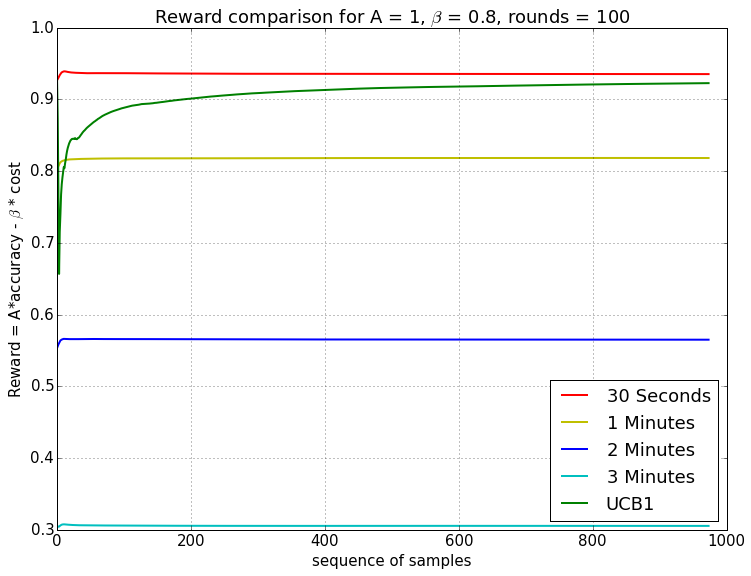

In [20]:
A = 1
beta = 0.8
rounds = 100
c_rewards_mean, ucb1_rewards_mean = multi_rounds_testing(db_clf_tuples, A=A, beta=beta, rounds=rounds,dbg=False)
plt.rcParams['figure.figsize'] = 12.0, 9.0
plt.rcParams.update({'font.size': 15})
xa = np.linspace(0, 973, num=973)
plt.plot(xa, c_rewards_mean[0], color='r', linewidth=2, label="30 Seconds")
plt.plot(xa, c_rewards_mean[1], color='y', linewidth=2, label="1 Minutes")
plt.plot(xa, c_rewards_mean[2], color='b', linewidth=2, label="2 Minutes")
plt.plot(xa, c_rewards_mean[3], color='c', linewidth=2, label="3 Minutes")
plt.plot(xa, ucb1_rewards_mean, color='g', linewidth=2, label="UCB1")
#plt.ylim([0.4,1])
plt.title("Reward comparison for A = {0}, $\\beta$ = {1}, rounds = {2}".format(A, beta, rounds))
plt.xlabel("sequence of samples")
plt.ylabel("Reward = A*accuracy - $\\beta$ * cost")
plt.grid()
plt.legend(loc=4)
plt.savefig('Rewards_beta_{0}_{1}.pdf'.format(beta,rounds))

Start the experiment... print the rand used to shuffle testing samples
845 432 820 305 45 276 281 777 475 957
112 948 18 386 460 723 539 334 689 267
298 995 279 299 239 850 811 739 313 617
251 694 738 785 732 76 190 151 739 470
896 604 305 842 395 614 206 427 851 657
295 903 789 554 196 631 217 455 406 893
783 467 84 831 787 389 289 156 420 7
957 781 693 451 316 821 159 852 342 602
619 174 766 947 117 733 786 93 608 989
887 602 772 70 227 230 58 258 56 987

Experiments done!


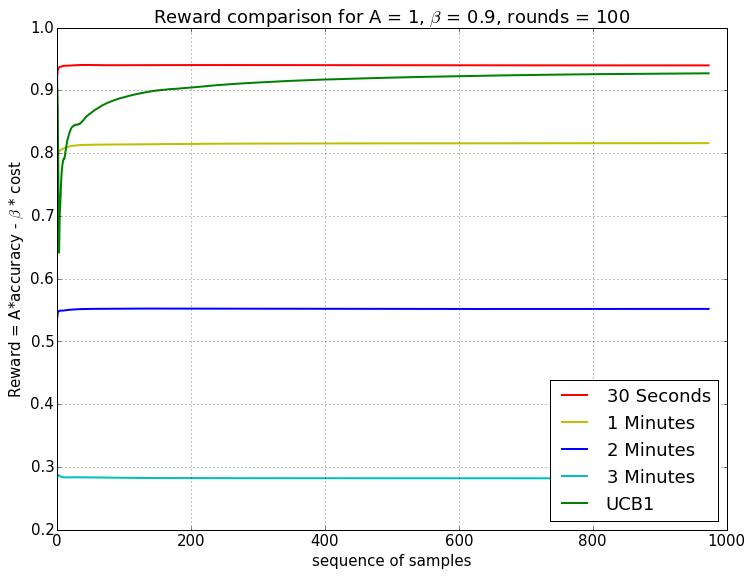

In [21]:
A = 1
beta = 0.9
rounds = 100
c_rewards_mean, ucb1_rewards_mean = multi_rounds_testing(db_clf_tuples, A=A, beta=beta, rounds=rounds,dbg=False)
plt.rcParams['figure.figsize'] = 12.0, 9.0
plt.rcParams.update({'font.size': 15})
xa = np.linspace(0, 973, num=973)
plt.plot(xa, c_rewards_mean[0], color='r', linewidth=2, label="30 Seconds")
plt.plot(xa, c_rewards_mean[1], color='y', linewidth=2, label="1 Minutes")
plt.plot(xa, c_rewards_mean[2], color='b', linewidth=2, label="2 Minutes")
plt.plot(xa, c_rewards_mean[3], color='c', linewidth=2, label="3 Minutes")
plt.plot(xa, ucb1_rewards_mean, color='g', linewidth=2, label="UCB1")
#plt.ylim([0.4,1])
plt.title("Reward comparison for A = {0}, $\\beta$ = {1}, rounds = {2}".format(A, beta, rounds))
plt.xlabel("sequence of samples")
plt.ylabel("Reward = A*accuracy - $\\beta$ * cost")
plt.grid()
plt.legend(loc=4)
plt.savefig('Rewards_beta_{0}_{1}.pdf'.format(beta,rounds))

## Classifiers used for Contextual UCB1 Testing

In [22]:
clf0_c = GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
clf1_c = GradientBoostingClassifier(init=None, learning_rate=1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
clf2_c =  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
clf3_c = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

clfs_c0 = [clf0_c, clf1_c, clf2_c, clf3_c]
clfs_c1 = [clf3_c, clf2_c, clf1_c, clf0_c]
clfs_c2 = [clf2_c, clf3_c, clf0_c, clf1_c]
clfs_c3 = [clf1_c, clf0_c, clf3_c, clf2_c]

#db_clf_tuples_context = [(db0m, clfs_c0), (db1m, clfs_c1), (db2m, clfs_c2), (db3m, clfs_c3)]
db_clf_tuples_context = [(db0m, clf0_c), (db1m, clf1_c), (db2m, clf2_c), (db3m, clf3_c)]
random=0

## Define a Contextual UCB1

In [23]:
class Contextual_Eval:
    def __init__(self, db, clfs, random=111, A=1, beta=0.01, k=0.5, dbg=False):
        self.bad_file_path = "/Volumes/SST3/Samples/ml_test_set_all_1315/"
        self.good_file_path = "/Volumes/SST3/Samples/gd_test_set_all_630/" 
        self.bad_file_list_by_size = [child for child in get_file_list_by_size(self.bad_file_path)\
                                      if child.find('._') == -1]
        self.good_file_list_by_size = [child for child in get_file_list_by_size(self.good_file_path)\
                                       if child.find('._') == -1]
        self.db = db
        self.clfs = clfs
        self.random = random
        #print self.random
        self.A = A
        self.beta = beta
        self.k = 0.5 if k == 0 else k
        self.X_train = []
        self.y_train = []
        self.X_test = []
        self.y_test = []
        self.y_pred = []
        self.rewards = []
        self.sum_rewards = 0
        self.dbg = dbg

    def reward_cal(self, y_test, y_pred):
        for i in range(len(y_pred)):
            accuracy = accuracy_score(y_test[0:i+1], y_pred[0:i+1])
            reward = self.A * (accuracy - self.beta * self.k)
            normalized = (reward + 3. * self.beta) / (1 + 2.5 * self.beta)
            self.sum_rewards += normalized
            #self.rewards.append(normalized)
            self.rewards.append(self.sum_rewards / (i+1))
            if self.dbg and i < 30 and False:
                print "{0}: Accuracy={1}".format(i+1, accuracy)
                print "{0}: y_test={1}".format(i+1, y_test[0:i+1])
                print "{0}: y_pred={1}".format(i+1, y_pred[0:i+1])
                print "{0}: ave_reward={1}".format(i+1, self.rewards)
            
            
    def load_dataframe(self, file_list, good_bad, db, t):
        # if .csv file exist, read features from .csv file
        csv_name = good_bad + "_" + t + ".csv"
        if os.path.exists(csv_name):
            df = pd.read_csv(csv_name)
        else:
            df = pd.DataFrame.from_records(load_all_profile_type1(file_list, db))
            cols = df.columns.tolist()
            cols.insert(0, cols.pop(cols.index('filename')))
            df = df.reindex(columns=cols)
            df['label'] = good_bad
            df.to_csv(csv_name, index=False)
        
        return df
    
    def dataframes_to_split_sets(self, df_bad, df_good, random):
        df = pd.concat([df_bad, df_good], ignore_index=True)
        df.replace(-1, 0, inplace=True)     # not found set to default -1 
        no_label = list(df.columns.values)
        no_label.remove('filename')
        no_label.remove('label')
        X = df.as_matrix(no_label)
        y = np.array(df['label'].tolist())
        lb = preprocessing.LabelBinarizer()
        y = lb.fit_transform(y).flatten()

        X_train, X_test, y_train, y_test = \
            cross_validation.train_test_split(X, y, test_size=0.5, random_state=random)

        return X_train, X_test, y_train, y_test
    
    def Analysis(self, rand): ##TODO: we didn't use variable rand
        df_bad = [self.load_dataframe(self.bad_file_list_by_size[  0: 329], 'bad', self.db, str(int(self.k)) + '_0'), 
                  self.load_dataframe(self.bad_file_list_by_size[329: 658], 'bad', self.db, str(int(self.k)) + '_1'),
                  self.load_dataframe(self.bad_file_list_by_size[658: 987], 'bad', self.db, str(int(self.k)) + '_2'),
                  self.load_dataframe(self.bad_file_list_by_size[987:1315], 'bad', self.db, str(int(self.k)) + '_3')]
        df_good = [self.load_dataframe(self.good_file_list_by_size[  0:157], 'good', self.db, str(int(self.k)) + '_0'),
                   self.load_dataframe(self.good_file_list_by_size[157:314], 'good', self.db, str(int(self.k)) + '_1'),
                   self.load_dataframe(self.good_file_list_by_size[314:472], 'good', self.db, str(int(self.k)) + '_2'),
                   self.load_dataframe(self.good_file_list_by_size[472:630], 'good', self.db, str(int(self.k)) + '_3')]

        #for i, (df_bad_x, df_good_x) in enumerate(zip(df_bad, df_good)):
        for df_bad_x, df_good_x in zip(df_bad, df_good):
            X_train_x, X_test_x, y_train_x, y_test_x = \
                self.dataframes_to_split_sets(df_bad_x, df_good_x, self.random)
            #self.clfs[i].fit(X_train_x[:, np.arange(1, X_train_x.shape[1])], y_train_x)
            #y_pred_x = self.clfs[i].predict(X_test_x[:,np.arange(1, X_test_x.shape[1])])
            X_test_x, y_test_x = shuffle(X_test_x, y_test_x, random_state=rand)    
            self.X_train.append(X_train_x)
            self.y_train.append(y_train_x)
            self.X_test.append(X_test_x)
            self.y_test.append(y_test_x)
            #print "{0}: len={1}".format(i, len(y_test_x))

        m = 0 if self.k == 0.5 else self.k
        self.clfs.fit(self.X_train[m][:, np.arange(1, self.X_train[m].shape[1])], self.y_train[m])
        
        y_test = []
        y_pred = []
        for j in [0, 1, 2, 3]:
            y_pred_x = self.clfs.predict(self.X_test[j][:,np.arange(1, self.X_test[j].shape[1])])
            self.y_pred.append(y_pred_x)
            y_test.extend(self.y_test[j])
            y_pred.extend(y_pred_x)
            accuracy = accuracy_score(self.y_test[j], y_pred_x)
            #print accuracy
        y_test, y_pred = shuffle(y_test, y_pred, random_state=rand)
        self.reward_cal(y_test, y_pred)
            
    def get_test_data(self):
        return self.X_test, self.y_test
    
    def get_test_result(self):
        return self.y_pred, self.y_test
    
    def get_rewards(self):
        return self.rewards

## Contextual UCB1 implementation (Apply UCB1 in 2 dimensions)

In [24]:
class UCB1_Context:
    def __init__(self, y_preds, y_tests, numActions, A=1, beta=0.01, dbg=False):
        self.y_tests = y_tests
        self.y_preds = y_preds
        self.numAction = numActions
        self.A = A
        self.beta = beta
        self.dbg = dbg
        self.y_pred_ucb = [[], [], [], []]
        self.y_test_ucb = [[], [], [], []]
        self.ucb1_rewards = []
        self.total_cost = [0] * 4
        self.accuracy =[0] * 4        
        
    def upperBound(self, step, numPlays):
        return math.sqrt(2 * math.log(step + 1) / numPlays)
    
    def reward(self, k, t): # This reward function could be shared by both with and without contextual
        b1 = len(self.y_tests[k][0])
        b2 = len(self.y_tests[k][1])
        b3 = len(self.y_tests[k][2])
        if t >= 0 and t < b1:
            c = 0
            i = t
        elif t >= b1 and t < (b1 + b2):
            c = 1
            i = t - b1
        elif t >= (b1 + b2) and t < (b1 + b2 + b3):
            c = 2
            i = t - (b1 + b2)
        else:
            c = 3
            i = t - (b1 + b2 + b3)
        #print "b1={0}, b2={1}, b3={2}, k={3}, i={4}".format(b1, b2, b3, k, i)
        self.y_test_ucb[k].append(self.y_tests[c][c][i])
        self.y_pred_ucb[k].append(self.y_preds[c][c][i])
        self.accuracy[k] = accuracy_score(self.y_test_ucb[k], self.y_pred_ucb[k])
        if self.dbg and t < 30:
            print "{0}: Accuracy={1}".format(t+1, self.accuracy[k])
            print "{0}: {1}".format(t+1, self.y_test_ucb[k])
            print "{0}: {1}".format(t+1, self.y_pred_ucb[k])
            
        reward = self.A * (self.accuracy[k] - self.beta * (0.5 if k == 0 else k))
        normalized = (reward + 3. * self.beta) / (1 + 2.5 * self.beta)
        return normalized
    
    def ucb1(self, numActions, reward):
        payoffSums = [0] * numActions
        numPlays = [1] * numActions
        ucbs = [0] * numActions

        #initialize empirical sums
        for n in range(numActions):
            payoffSums[n] = reward(n, n)
            ucbs[n] = payoffSums[n]
            yield n, payoffSums[n], ucbs

        t = numActions

        while True:
            ucbs = [payoffSums[i] / numPlays[i] + self.upperBound(t, numPlays[i]) for i in range(numActions)]
            action = max(range(numActions), key = lambda i: ucbs[i])
            theReward = reward(action, t)
            numPlays[action] += 1
            payoffSums[action] += theReward

            yield action, theReward, ucbs
            t = t + 1
    
    def Testing(self):
        #numActions = 4
        #self.ucb1_rewards = []
        numRounds = len(self.y_tests[0][0]) + len(self.y_tests[0][1]) \
                  + len(self.y_tests[0][2]) + len(self.y_tests[0][3])

        cumulativeReward = 0
        total_time = 0
        positives = 0
        if self.dbg:
            print("========== debug UCB1 flag is turned on ==========")
        #t = self.numAction
        t = 1 #round counter
        for (choice, reward, ucbs) in self.ucb1(self.numAction, self.reward):
            cumulativeReward += reward
            total_time += choice
            if self.dbg:
                print("%d: choice: %d\treward: %f" % (t, choice, reward)), 
                print ucbs
            #self.ucb1_rewards.append(reward)
            self.ucb1_rewards.append(cumulativeReward / t)
            t += 1
            if t > numRounds:
                break

## Contexutal based UCB1 calculation

In [25]:
def multi_rounds_testing_contextual(db_clf_tuples, A=1, beta=0.01, rounds=100, dbg=False):
    rand_states = np.random.randint(1000, size=rounds)
    #rand_states = [87]
    c_rewards_total = []
    ucb1_rewards_total = []
    print "Start the experiment... print the rand used to shuffle testing samples"
    for c, rand in enumerate(rand_states, start=1):
        X_tests = []
        y_tests = []
        y_preds = []
        c_rewards = []
        for i, db_clf_tuple in enumerate(db_clf_tuples):
            the_data = Contextual_Eval(db_clf_tuple[0], db_clf_tuple[1], random=random, A=A, beta=beta, k=i, dbg=dbg)
            the_data.Analysis(rand)
            c_rewards.append(the_data.get_rewards())
            X_test, y_test = the_data.get_test_data()
            y_pred, y_test = the_data.get_test_result()
            X_tests.append(X_test)
            y_tests.append(y_test)
            y_preds.append(y_pred)

        if len(c_rewards_total) == 0:
            c_rewards_total = np.matrix(c_rewards)
        else:
            c_rewards_total = np.matrix(c_rewards_total) + np.matrix(c_rewards)

        UCB1_obj = UCB1_Context(y_preds, y_tests, 4, A=A, beta=beta, dbg=dbg)
        UCB1_obj.Testing()
        ucb1_rewards = UCB1_obj.ucb1_rewards
        if len(ucb1_rewards_total) == 0:
            ucb1_rewards_total = ucb1_rewards
        else:
            ucb1_rewards_total = [a + b for a, b in zip(ucb1_rewards_total, ucb1_rewards)]
        if (c % 10 == 0):    
            print rand
        else:
            print rand,
    print "\nExperiment done!"
    c_rewards_mean = c_rewards_total / float(rounds)
    c_rewards_mean = c_rewards_mean.tolist()
    ucb1_rewards_mean = [x / float(rounds) for x in ucb1_rewards_total]
    
    return c_rewards_mean, ucb1_rewards_mean

## Contextual Bandit Testing

In [26]:
A=1
beta = 0
rounds = 100
c_rewards_mean, ucb1_rewards_mean = multi_rounds_testing_contextual(db_clf_tuples_context, A=A, beta=beta, 
                                                                    rounds=rounds, dbg=False)
plt.rcParams['figure.figsize'] = 12.0, 9.0
plt.rcParams.update({'font.size': 15})
xa = np.linspace(0, 973, num=973)
plt.plot(xa, c_rewards_mean[0], color='r', linewidth=2, label="30 Seconds")
plt.plot(xa, c_rewards_mean[1], color='y', linewidth=2, label="1 Minutes")
plt.plot(xa, c_rewards_mean[2], color='b', linewidth=2, label="2 Minutes")
plt.plot(xa, c_rewards_mean[3], color='c', linewidth=2, label="3 Minutes")
plt.plot(xa, ucb1_rewards_mean, color='g', linewidth=2, label="UCB1")
#plt.ylim([0.4,1])
plt.title("Reward comparison for A = {0}, $\\beta$ = {1}, rounds = {2}".format(A, beta, rounds))
plt.xlabel("sequence of samples")
plt.ylabel("Reward = A*(accuracy - $\\beta$ * cost)")
plt.grid()
plt.legend(loc=4)
plt.savefig('Rewards_beta_{0}_{1}.pdf'.format(beta,rounds))

Start the experiment... print the rand used to shuffle testing samples
122 699 986 884 549 750 340 494 277 331
218 129 909 767 36 640 211 216 539 281
896 743 69 625 764 959 780 11 617 612
603 79 179 237 273 281 94 588 544 204
284 535 53 806 710 490 823 987 183 219
175 16 266 832 333 442 686 176 766 150
279 102 82 927 289 437 1 91 565 200
965 920 4 717 862 657 109 27 968 603
773 113 32 580 148 208 429 189 377 510
49 218 951 716 237 414 219 232 638 570

Experiment done!


In [27]:
A=1
beta = 0.1
rounds = 100
c_rewards_mean, ucb1_rewards_mean = multi_rounds_testing_contextual(db_clf_tuples_context, A=A, beta=beta, 
                                                                    rounds=rounds, dbg=False)
plt.rcParams['figure.figsize'] = 12.0, 9.0
plt.rcParams.update({'font.size': 15})
xa = np.linspace(0, 973, num=973)
plt.plot(xa, c_rewards_mean[0], color='r', linewidth=2, label="30 Seconds")
plt.plot(xa, c_rewards_mean[1], color='y', linewidth=2, label="1 Minutes")
plt.plot(xa, c_rewards_mean[2], color='b', linewidth=2, label="2 Minutes")
plt.plot(xa, c_rewards_mean[3], color='c', linewidth=2, label="3 Minutes")
plt.plot(xa, ucb1_rewards_mean, color='g', linewidth=2, label="UCB1")
#plt.ylim([0.4,1])
plt.title("Reward comparison for A = {0}, $\\beta$ = {1}, rounds = {2}".format(A, beta, rounds))
plt.xlabel("sequence of samples")
plt.ylabel("Reward = A*(accuracy - $\\beta$ * cost)")
plt.grid()
plt.legend(loc=4)
plt.savefig('Rewards_beta_{0}_{1}.pdf'.format(beta,rounds))

Start the experiment... print the rand used to shuffle testing samples
704 343 363 111 588 891 502 72 208 784
859 807 832 480 160 46 696 985 736 170
923 298 362 12 262 346 969 124 507 32
420 95 100 227 296 731 140 182 361 393
858 233 451 682 249 564 201 316 833 450
87 888 29 33 982 729 607 966 910 138
185 256 916 813 885 68 400 960 188 680
405 143 433 55 348 264 393 111 652 420
415 709 700 645 762 607 337 400 428 606
678 878 975 664 691 213 251 710 264 860

Experiment done!


Start the experiment... print the rand used to shuffle testing samples
673 234 753 989 459 682 275 21 109 330
564 256 160 589 997 510 626 731 679 589
593 282 562 118 278 936 70 406 776 375
133 151 914 655 663 403 370 748 204 182
516 173 926 707 217 424 727 201 375 301
350 430 265 122 345 684 720 984 927 621
404 785 744 923 39 428 681 250 582 346
182 841 996 51 919 523 593 826 490 961
921 296 217 658 73 16 724 339 919 100
604 632 718 248 108 453 90 157 895 217

Experiment done!


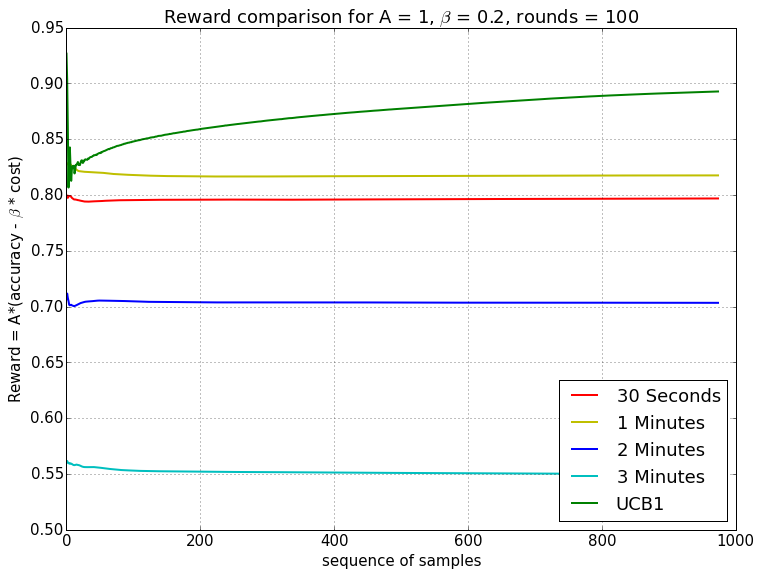

In [28]:
A=1
beta = 0.2
rounds = 100
c_rewards_mean, ucb1_rewards_mean = multi_rounds_testing_contextual(db_clf_tuples_context, A=A, beta=beta, 
                                                                    rounds=rounds, dbg=False)
plt.rcParams['figure.figsize'] = 12.0, 9.0
plt.rcParams.update({'font.size': 15})
xa = np.linspace(0, 973, num=973)
plt.plot(xa, c_rewards_mean[0], color='r', linewidth=2, label="30 Seconds")
plt.plot(xa, c_rewards_mean[1], color='y', linewidth=2, label="1 Minutes")
plt.plot(xa, c_rewards_mean[2], color='b', linewidth=2, label="2 Minutes")
plt.plot(xa, c_rewards_mean[3], color='c', linewidth=2, label="3 Minutes")
plt.plot(xa, ucb1_rewards_mean, color='g', linewidth=2, label="UCB1")
#plt.ylim([0.4,1])
plt.title("Reward comparison for A = {0}, $\\beta$ = {1}, rounds = {2}".format(A, beta, rounds))
plt.xlabel("sequence of samples")
plt.ylabel("Reward = A*(accuracy - $\\beta$ * cost)")
plt.grid()
plt.legend(loc=4)
plt.savefig('Rewards_beta_{0}_{1}.pdf'.format(beta,rounds))

Start the experiment... print the rand used to shuffle testing samples
141 425 44 967 561 833 109 974 506 328
41 50 843 152 852 368 491 851 510 63
607 194 362 615 966 461 412 140 792 214
354 780 183 876 167 897 52 268 200 691
936 914 941 38 733 153 849 570 292 464
520 420 656 522 847 947 797 811 119 280
445 217 253 459 209 518 452 680 160 255
772 107 325 337 664 796 466 592 298 74
366 350 153 552 890 800 937 302 851 684
937 522 820 560 639 964 611 441 508 475

Experiment done!


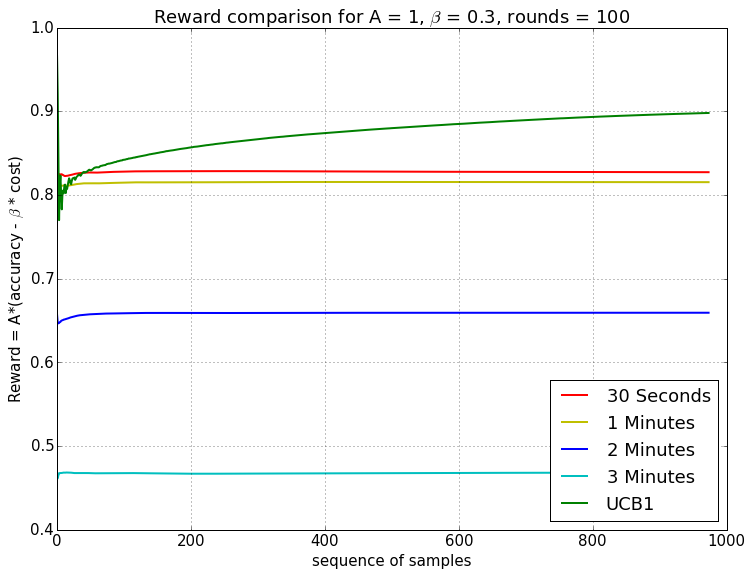

In [29]:
A=1
beta = 0.3
rounds = 100
c_rewards_mean, ucb1_rewards_mean = multi_rounds_testing_contextual(db_clf_tuples_context, A=A, beta=beta, 
                                                                    rounds=rounds, dbg=False)
plt.rcParams['figure.figsize'] = 12.0, 9.0
plt.rcParams.update({'font.size': 15})
xa = np.linspace(0, 973, num=973)
plt.plot(xa, c_rewards_mean[0], color='r', linewidth=2, label="30 Seconds")
plt.plot(xa, c_rewards_mean[1], color='y', linewidth=2, label="1 Minutes")
plt.plot(xa, c_rewards_mean[2], color='b', linewidth=2, label="2 Minutes")
plt.plot(xa, c_rewards_mean[3], color='c', linewidth=2, label="3 Minutes")
plt.plot(xa, ucb1_rewards_mean, color='g', linewidth=2, label="UCB1")
#plt.ylim([0.4,1])
plt.title("Reward comparison for A = {0}, $\\beta$ = {1}, rounds = {2}".format(A, beta, rounds))
plt.xlabel("sequence of samples")
plt.ylabel("Reward = A*(accuracy - $\\beta$ * cost)")
plt.grid()
plt.legend(loc=4)
plt.savefig('Rewards_beta_{0}_{1}.pdf'.format(beta,rounds))

Start the experiment... print the rand used to shuffle testing samples
673 426 732 764 563 596 798 296 782 534
398 499 502 309 778 625 522 412 6 382
687 827 829 413 723 961 641 998 631 316
733 448 801 3 112 599 623 246 953 75
617 558 923 663 136 205 733 124 189 344
249 352 557 297 115 497 270 400 488 807
694 48 365 129 712 831 12 16 307 601
697 366 135 319 983 245 160 885 884 205
43 917 946 318 882 328 251 238 178 877
404 408 950 796 36 549 724 825 326 605

Experiment done!


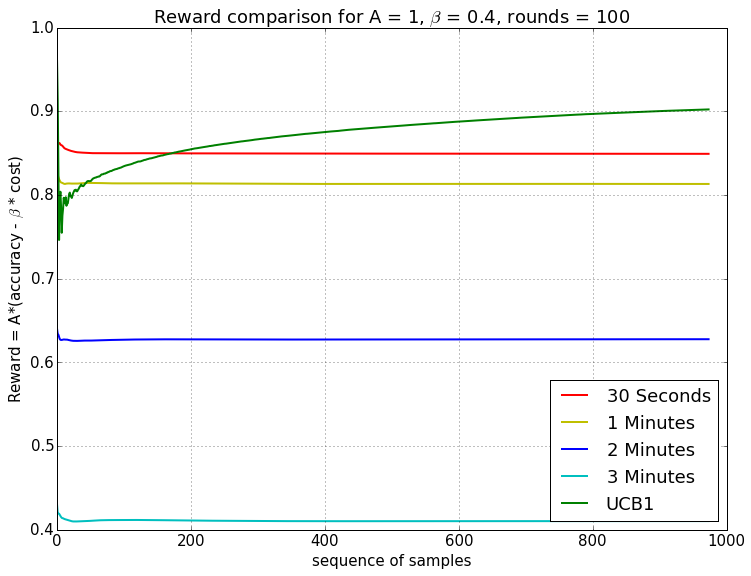

In [30]:
A=1
beta = 0.4
rounds = 100
c_rewards_mean, ucb1_rewards_mean = multi_rounds_testing_contextual(db_clf_tuples_context, A=A, beta=beta, 
                                                                    rounds=rounds, dbg=False)
plt.rcParams['figure.figsize'] = 12.0, 9.0
plt.rcParams.update({'font.size': 15})
xa = np.linspace(0, 973, num=973)
plt.plot(xa, c_rewards_mean[0], color='r', linewidth=2, label="30 Seconds")
plt.plot(xa, c_rewards_mean[1], color='y', linewidth=2, label="1 Minutes")
plt.plot(xa, c_rewards_mean[2], color='b', linewidth=2, label="2 Minutes")
plt.plot(xa, c_rewards_mean[3], color='c', linewidth=2, label="3 Minutes")
plt.plot(xa, ucb1_rewards_mean, color='g', linewidth=2, label="UCB1")
#plt.ylim([0.4,1])
plt.title("Reward comparison for A = {0}, $\\beta$ = {1}, rounds = {2}".format(A, beta, rounds))
plt.xlabel("sequence of samples")
plt.ylabel("Reward = A*(accuracy - $\\beta$ * cost)")
plt.grid()
plt.legend(loc=4)
plt.savefig('Rewards_beta_{0}_{1}.pdf'.format(beta,rounds))

Start the experiment... print the rand used to shuffle testing samples
485 614 958 456 64 32 626 852 677 708
664 730 666 899 996 434 741 726 294 398
73 70 430 195 679 373 654 303 730 21
536 919 451 577 233 447 63 42 387 711
229 323 659 837 624 218 651 857 514 800
650 424 393 195 780 308 810 437 75 252
980 876 90 567 213 221 306 170 523 54
374 56 831 693 959 517 688 30 767 49
903 854 242 630 960 860 491 783 521 828
37 503 501 265 508 997 170 880 193 564

Experiment done!


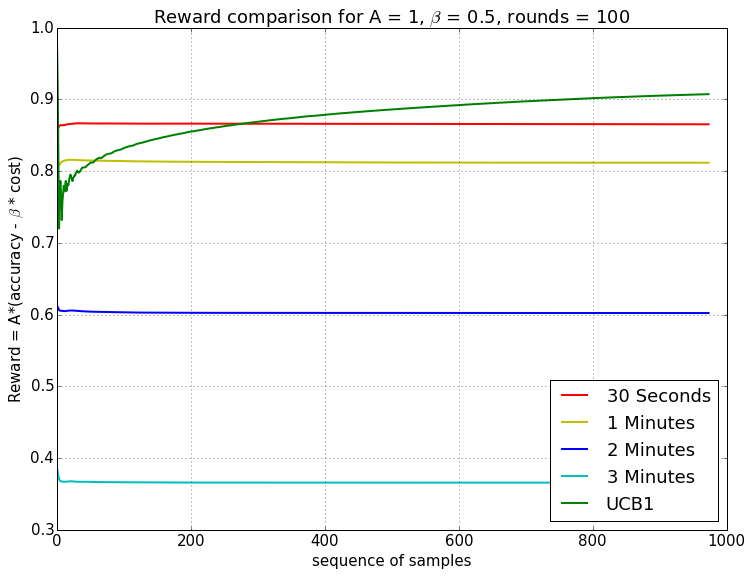

In [31]:
A=1
beta = 0.5
rounds = 100
c_rewards_mean, ucb1_rewards_mean = multi_rounds_testing_contextual(db_clf_tuples_context, A=A, beta=beta, 
                                                                    rounds=rounds, dbg=False)
plt.rcParams['figure.figsize'] = 12.0, 9.0
plt.rcParams.update({'font.size': 15})
xa = np.linspace(0, 973, num=973)
plt.plot(xa, c_rewards_mean[0], color='r', linewidth=2, label="30 Seconds")
plt.plot(xa, c_rewards_mean[1], color='y', linewidth=2, label="1 Minutes")
plt.plot(xa, c_rewards_mean[2], color='b', linewidth=2, label="2 Minutes")
plt.plot(xa, c_rewards_mean[3], color='c', linewidth=2, label="3 Minutes")
plt.plot(xa, ucb1_rewards_mean, color='g', linewidth=2, label="UCB1")
#plt.ylim([0.4,1])
plt.title("Reward comparison for A = {0}, $\\beta$ = {1}, rounds = {2}".format(A, beta, rounds))
plt.xlabel("sequence of samples")
plt.ylabel("Reward = A*(accuracy - $\\beta$ * cost)")
plt.grid()
plt.legend(loc=4)
plt.savefig('Rewards_beta_{0}_{1}.pdf'.format(beta,rounds))

Start the experiment... print the rand used to shuffle testing samples
995 594 660 557 632 593 479 247 800 726
984 792 837 285 454 724 871 544 826 395
234 834 975 525 894 624 975 545 810 853
150 744 520 578 435 299 358 862 63 287
826 665 842 711 314 890 322 928 623 971
69 932 260 350 343 236 535 202 604 889
970 70 235 703 730 685 135 213 264 441
395 219 567 526 399 217 959 440 741 191
528 832 561 63 414 770 812 605 784 860
15 439 534 702 86 327 704 540 494 675

Experiment done!


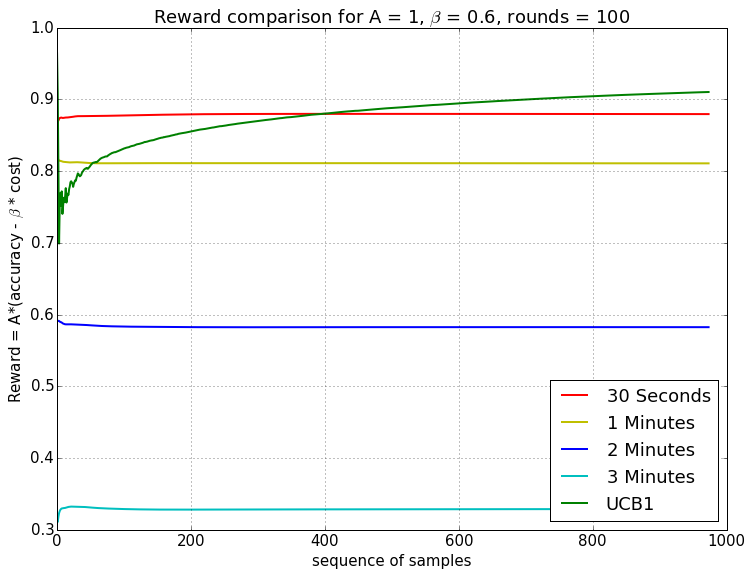

In [32]:
A=1
beta = 0.6
rounds = 100
c_rewards_mean, ucb1_rewards_mean = multi_rounds_testing_contextual(db_clf_tuples_context, A=A, beta=beta, 
                                                                    rounds=rounds, dbg=False)
plt.rcParams['figure.figsize'] = 12.0, 9.0
plt.rcParams.update({'font.size': 15})
xa = np.linspace(0, 973, num=973)
plt.plot(xa, c_rewards_mean[0], color='r', linewidth=2, label="30 Seconds")
plt.plot(xa, c_rewards_mean[1], color='y', linewidth=2, label="1 Minutes")
plt.plot(xa, c_rewards_mean[2], color='b', linewidth=2, label="2 Minutes")
plt.plot(xa, c_rewards_mean[3], color='c', linewidth=2, label="3 Minutes")
plt.plot(xa, ucb1_rewards_mean, color='g', linewidth=2, label="UCB1")
#plt.ylim([0.4,1])
plt.title("Reward comparison for A = {0}, $\\beta$ = {1}, rounds = {2}".format(A, beta, rounds))
plt.xlabel("sequence of samples")
plt.ylabel("Reward = A*(accuracy - $\\beta$ * cost)")
plt.grid()
plt.legend(loc=4)
plt.savefig('Rewards_beta_{0}_{1}.pdf'.format(beta,rounds))

Start the experiment... print the rand used to shuffle testing samples
178 166 958 660 221 391 650 202 547 7
325 275 249 483 255 395 760 330 331 548
76 425 337 181 818 781 899 257 791 967
951 720 42 54 550 822 953 562 9 520
953 747 414 260 564 992 641 136 366 794
277 114 412 560 213 688 283 775 849 577
597 362 356 223 308 864 867 225 96 19
95 655 860 870 396 945 182 680 771 407
647 787 86 674 205 468 820 505 617 20
483 825 608 33 376 769 370 833 534 922

Experiment done!


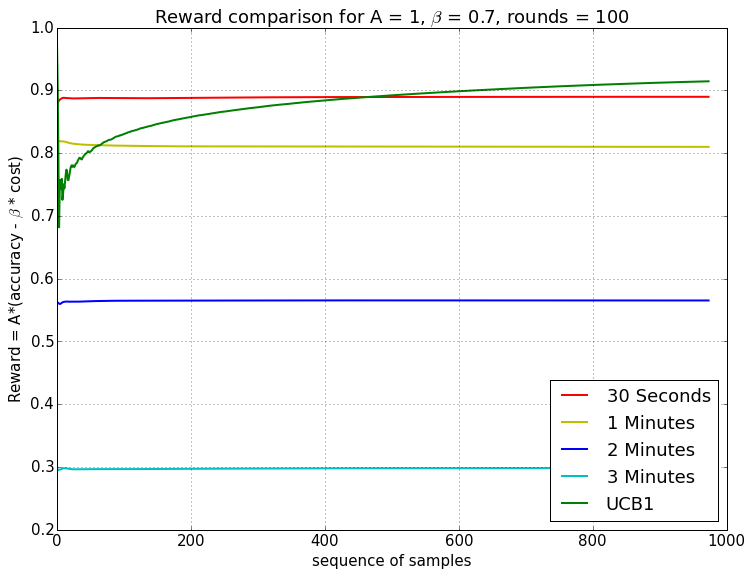

In [33]:
A=1
beta = 0.7
rounds = 100
c_rewards_mean, ucb1_rewards_mean = multi_rounds_testing_contextual(db_clf_tuples_context, A=A, beta=beta, 
                                                                    rounds=rounds, dbg=False)
plt.rcParams['figure.figsize'] = 12.0, 9.0
plt.rcParams.update({'font.size': 15})
xa = np.linspace(0, 973, num=973)
plt.plot(xa, c_rewards_mean[0], color='r', linewidth=2, label="30 Seconds")
plt.plot(xa, c_rewards_mean[1], color='y', linewidth=2, label="1 Minutes")
plt.plot(xa, c_rewards_mean[2], color='b', linewidth=2, label="2 Minutes")
plt.plot(xa, c_rewards_mean[3], color='c', linewidth=2, label="3 Minutes")
plt.plot(xa, ucb1_rewards_mean, color='g', linewidth=2, label="UCB1")
#plt.ylim([0.4,1])
plt.title("Reward comparison for A = {0}, $\\beta$ = {1}, rounds = {2}".format(A, beta, rounds))
plt.xlabel("sequence of samples")
plt.ylabel("Reward = A*(accuracy - $\\beta$ * cost)")
plt.grid()
plt.legend(loc=4)
plt.savefig('Rewards_beta_{0}_{1}.pdf'.format(beta,rounds))

Start the experiment... print the rand used to shuffle testing samples
92 665 828 218 713 552 337 320 312 37
577 287 748 303 141 65 186 142 716 968
887 416 236 0 660 423 315 870 966 604
913 250 690 11 507 177 923 32 302 302
815 745 852 107 654 951 384 969 537 293
888 605 345 246 94 762 749 563 589 424
646 766 522 749 555 230 642 538 216 10
861 309 726 249 638 226 931 868 114 866
923 604 905 271 790 902 444 426 763 363
103 204 986 765 536 622 988 826 552 336

Experiment done!


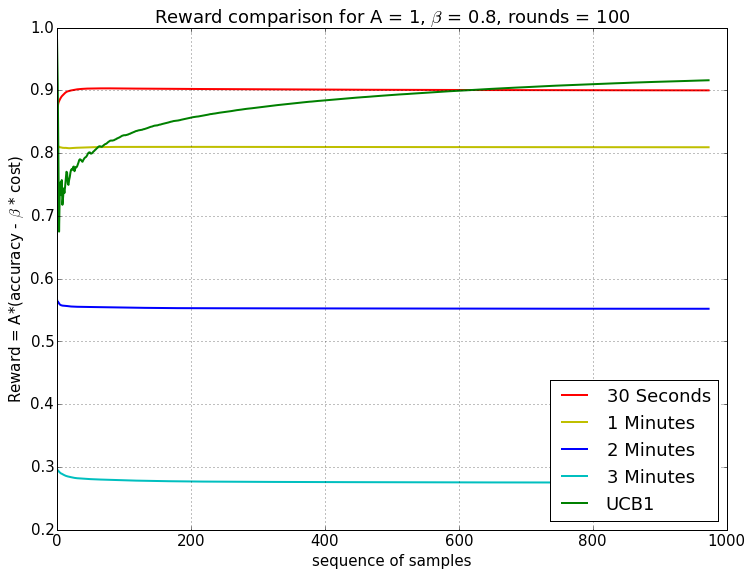

In [34]:
A=1
beta = 0.8
rounds = 100
c_rewards_mean, ucb1_rewards_mean = multi_rounds_testing_contextual(db_clf_tuples_context, A=A, beta=beta, 
                                                                    rounds=rounds, dbg=False)
plt.rcParams['figure.figsize'] = 12.0, 9.0
plt.rcParams.update({'font.size': 15})
xa = np.linspace(0, 973, num=973)
plt.plot(xa, c_rewards_mean[0], color='r', linewidth=2, label="30 Seconds")
plt.plot(xa, c_rewards_mean[1], color='y', linewidth=2, label="1 Minutes")
plt.plot(xa, c_rewards_mean[2], color='b', linewidth=2, label="2 Minutes")
plt.plot(xa, c_rewards_mean[3], color='c', linewidth=2, label="3 Minutes")
plt.plot(xa, ucb1_rewards_mean, color='g', linewidth=2, label="UCB1")
#plt.ylim([0.4,1])
plt.title("Reward comparison for A = {0}, $\\beta$ = {1}, rounds = {2}".format(A, beta, rounds))
plt.xlabel("sequence of samples")
plt.ylabel("Reward = A*(accuracy - $\\beta$ * cost)")
plt.grid()
plt.legend(loc=4)
plt.savefig('Rewards_beta_{0}_{1}.pdf'.format(beta,rounds))

Start the experiment... print the rand used to shuffle testing samples
128 772 758 578 547 608 574 382 229 957
361 739 109 761 784 27 472 986 338 819
36 406 675 159 378 936 260 138 169 815
450 359 414 320 802 969 678 536 653 523
469 124 981 526 936 305 28 809 972 378
555 956 438 589 219 668 956 907 333 592
585 622 727 634 372 15 13 735 96 699
817 507 957 403 560 996 670 920 170 24
161 605 638 132 112 360 332 804 115 15
778 473 267 284 663 308 560 370 257 158

Experiment done!


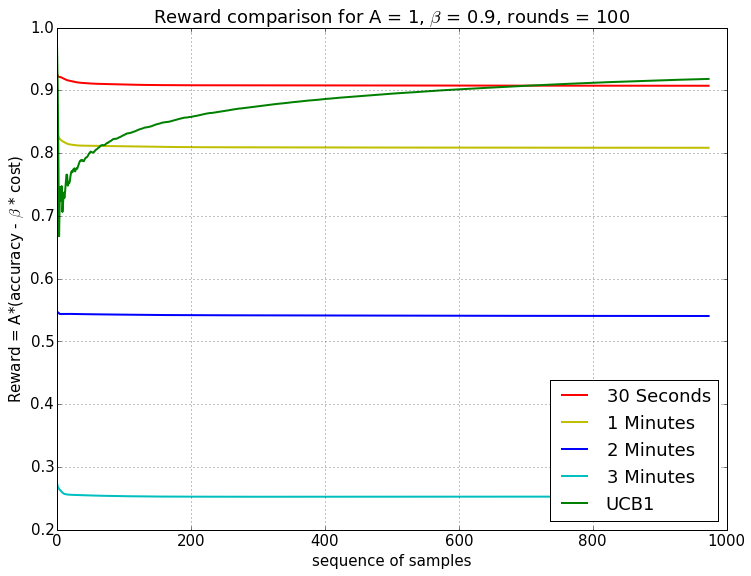

In [35]:
A=1
beta = 0.9
rounds = 100
c_rewards_mean, ucb1_rewards_mean = multi_rounds_testing_contextual(db_clf_tuples_context, A=A, beta=beta, 
                                                                    rounds=rounds, dbg=False)
plt.rcParams['figure.figsize'] = 12.0, 9.0
plt.rcParams.update({'font.size': 15})
xa = np.linspace(0, 973, num=973)
plt.plot(xa, c_rewards_mean[0], color='r', linewidth=2, label="30 Seconds")
plt.plot(xa, c_rewards_mean[1], color='y', linewidth=2, label="1 Minutes")
plt.plot(xa, c_rewards_mean[2], color='b', linewidth=2, label="2 Minutes")
plt.plot(xa, c_rewards_mean[3], color='c', linewidth=2, label="3 Minutes")
plt.plot(xa, ucb1_rewards_mean, color='g', linewidth=2, label="UCB1")
#plt.ylim([0.4,1])
plt.title("Reward comparison for A = {0}, $\\beta$ = {1}, rounds = {2}".format(A, beta, rounds))
plt.xlabel("sequence of samples")
plt.ylabel("Reward = A*(accuracy - $\\beta$ * cost)")
plt.grid()
plt.legend(loc=4)
plt.savefig('Rewards_beta_{0}_{1}.pdf'.format(beta,rounds))

Start the experiment... print the rand used to shuffle testing samples
567 428 542 700 937 503 259 574 913 982
91 537 686 380 451 775 310 767 785 804
44 675 501 612 915 867 144 370 931 791
775 881 322 217 336 466 876 8 195 985
3 18 105 602 772 712 283 706 134 906
839 27 360 187 693 920 987 127 692 796
252 129 971 125 947 612 893 417 603 10
385 852 904 115 163 117 676 696 943 567
695 566 65 196 126 225 878 538 356 832
635 625 655 798 325 619 577 437 711 159

Experiment done!


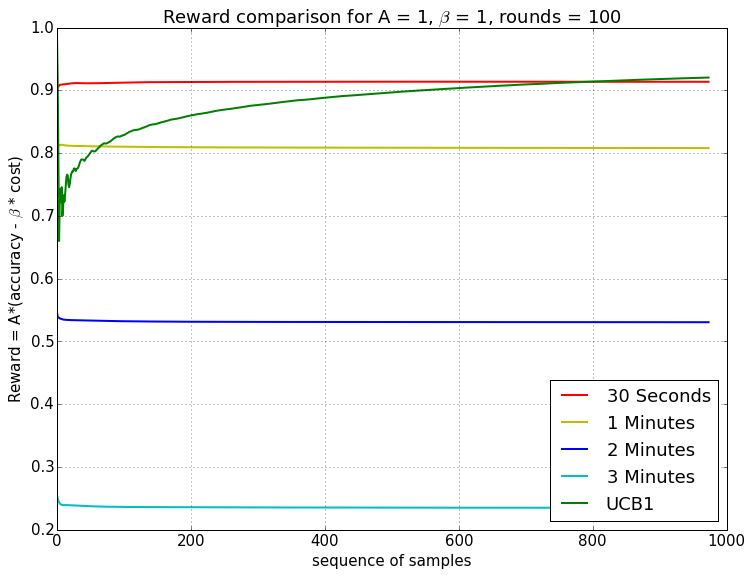

In [36]:
A=1
beta = 1
rounds = 100
c_rewards_mean, ucb1_rewards_mean = multi_rounds_testing_contextual(db_clf_tuples_context, A=A, beta=beta, 
                                                                    rounds=rounds, dbg=False)
plt.rcParams['figure.figsize'] = 12.0, 9.0
plt.rcParams.update({'font.size': 15})
xa = np.linspace(0, 973, num=973)
plt.plot(xa, c_rewards_mean[0], color='r', linewidth=2, label="30 Seconds")
plt.plot(xa, c_rewards_mean[1], color='y', linewidth=2, label="1 Minutes")
plt.plot(xa, c_rewards_mean[2], color='b', linewidth=2, label="2 Minutes")
plt.plot(xa, c_rewards_mean[3], color='c', linewidth=2, label="3 Minutes")
plt.plot(xa, ucb1_rewards_mean, color='g', linewidth=2, label="UCB1")
#plt.ylim([0.4,1])
plt.title("Reward comparison for A = {0}, $\\beta$ = {1}, rounds = {2}".format(A, beta, rounds))
plt.xlabel("sequence of samples")
plt.ylabel("Reward = A*(accuracy - $\\beta$ * cost)")
plt.grid()
plt.legend(loc=4)
plt.savefig('Rewards_beta_{0}_{1}.pdf'.format(beta,rounds))

## Grid search Helper

In [607]:
models = {
    'LogisticRegression': LogisticRegression(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'SVC': SVC(probability=True),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'DummyClassifier': DummyClassifier(),
}

param_grid = { 
    'LogisticRegression': { 'C': [1e-2,0.1, 1, 10], 'penalty': ['l1', 'l2'] },
    'DecisionTreeClassifier': { 'criterion': ['gini', 'entropy'], 'min_samples_split': [4, 8, 16, 32], 'min_samples_leaf': [8, 16, 32] },
    'RandomForestClassifier': { 'criterion': ['gini', 'entropy'], 'n_estimators': [10, 100] },
    'GradientBoostingClassifier': { 'n_estimators': [10, 100], 'learning_rate': [1e-2, 0.1, 1, 10] },
    'SVC': { 'kernel': ['rbf'], 'gamma': [1e-1, 1e-2, 1e-3], 'C': [1e-3, 1e-2, 0.1, 1, 10] },
    'AdaBoostClassifier': {'learning_rate': [1e-2, 0.1, 1, 10], 'n_estimators': [100, 1000,]},
    'KNeighborsClassifier': {'weights': ['uniform', 'distance'], 'n_neighbors': [5, 10, 20, 30] },
    'DummyClassifier': {'strategy': ['stratified'] },
}

In [401]:
class GridSearchHelper:
    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}
    
    def fit(self, X, y, cv=3, n_jobs=1, verbose=1, scoring=None, refit=True):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, 
                              verbose=verbose, scoring=scoring, refit=refit)
            gs.fit(X,y)
            self.grid_searches[key] = gs    
    
    def get_model_keys_sorted(self):
        keys_sorted = []
        best_list = []
        for key in self.keys:
            best_list.append(self.get_best(model=key))
            
        best_list_sorted = sorted(best_list, key=itemgetter("best_score"), reverse=True)
        for est in best_list_sorted:
            keys_sorted.append(est['model'])
        
        return keys_sorted
        
    def get_model_keys(self):
        return self.keys
    
    def get_best(self, model=None):
        best = {
            'model': model,
            'estimator': self.grid_searches[model].best_estimator_,
            'best_score': self.grid_searches[model].best_score_,
            'best_params': self.grid_searches[model].best_params_,
        }
    
        return best
        
    def get_best_best(self):
        best_list = []
        for key in self.keys:
            best_list.append(self.get_best(model=key))
            
        best_best = sorted(best_list, key=itemgetter("best_score"), reverse=True)[0]
            
        return best_best
        
    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': np.min(scores),
                 'max_score': np.max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series(dict(params.items() + d.items()))
                      
        rows = [row(k, gsc.cv_validation_scores, gsc.parameters) 
                for k in self.keys
                for gsc in self.grid_searches[k].grid_scores_]
        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        
        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        
        return df[columns]

## Define class to generate data for grid search

In [402]:
class Data_For_GridSearch:
    def __init__(self, db, random=111, k=0.5):
        self.bad_file_path = "/Volumes/SST3/Samples/ml_test_set_all_1315/"
        self.good_file_path = "/Volumes/SST3/Samples/gd_test_set_all_630/" 
        self.bad_file_list_by_size = [child for child in get_file_list_by_size(self.bad_file_path)\
                                      if child.find('._') == -1]
        self.good_file_list_by_size = [child for child in get_file_list_by_size(self.good_file_path)\
                                       if child.find('._') == -1]
        self.db = db
        self.random = random
        self.k = k
        self.X_train = []
        self.y_train = []
        self.X_test = []
        self.y_test = []
        self.X_x = []
        self.y_x = []
    
    def load_dataframe(self, file_list, good_bad, db, t):
        # if .csv file exist, read features from .csv file
        csv_name = good_bad + "_" + t + ".csv"
        if os.path.exists(csv_name):
            df = pd.read_csv(csv_name)
        else:
            df = pd.DataFrame.from_records(load_all_profile_type1(file_list, db))
            cols = df.columns.tolist()
            cols.insert(0, cols.pop(cols.index('filename')))
            df = df.reindex(columns=cols)
            df['label'] = good_bad
            df.to_csv(csv_name, index=False)
        
        return df
    
    def dataframes_to_split_sets(self, df_bad, df_good, random):
        df = pd.concat([df_bad, df_good], ignore_index=True)
        df.replace(-1, 0, inplace=True)     # not found set to default -1 
        no_label = list(df.columns.values)
        no_label.remove('filename')
        no_label.remove('label')
        X = df.as_matrix(no_label)
        y = np.array(df['label'].tolist())
        lb = preprocessing.LabelBinarizer()
        y = lb.fit_transform(y).flatten()

        X_train, X_test, y_train, y_test = \
            cross_validation.train_test_split(X, y, test_size=0.5, random_state=random)
        return X_train, X_test, y_train, y_test
    
    def gen_GSData(self): ##TODO: we didn't use variable rand
        df_bad = [self.load_dataframe(self.bad_file_list_by_size[  0: 329], 'bad', self.db, str(int(self.k)) + '_0'), 
                  self.load_dataframe(self.bad_file_list_by_size[329: 658], 'bad', self.db, str(int(self.k)) + '_1'),
                  self.load_dataframe(self.bad_file_list_by_size[658: 987], 'bad', self.db, str(int(self.k)) + '_2'),
                  self.load_dataframe(self.bad_file_list_by_size[987:1315], 'bad', self.db, str(int(self.k)) + '_3')]
        df_good = [self.load_dataframe(self.good_file_list_by_size[  0:157], 'good', self.db, str(int(self.k)) + '_0'),
                   self.load_dataframe(self.good_file_list_by_size[157:314], 'good', self.db, str(int(self.k)) + '_1'),
                   self.load_dataframe(self.good_file_list_by_size[314:472], 'good', self.db, str(int(self.k)) + '_2'),
                   self.load_dataframe(self.good_file_list_by_size[472:630], 'good', self.db, str(int(self.k)) + '_3')]
        for df_bad_x, df_good_x in zip(df_bad, df_good):
            X_train_x, X_test_x, y_train_x, y_test_x = \
                self.dataframes_to_split_sets(df_bad_x, df_good_x, self.random)
            self.X_train.append(X_train_x)
            self.y_train.append(y_train_x)
            self.X_test.append(X_test_x)
            self.y_test.append(y_test_x)
            
    def get_train_data(self):
        return self.X_train, self.y_train
    
    def get_test_data(self):
        return self.X_test, self.y_test

In [405]:
index = 0
print random
data_1 = Data_For_GridSearch(db0m, random=random, k=0)
data_1.gen_GSData()

0


In [406]:
X_trains, y_trains = data_1.get_train_data()
X_tests, y_tests = data_1.get_test_data()
X_gs = X_trains[index][:, np.arange(1, X_trains[index].shape[1])]
y_gs = y_trains[index]
gs = GridSearchHelper(models, param_grid)
gs_cv = cross_validation.StratifiedShuffleSplit(y_gs, n_iter=5, test_size=0.2, random_state=111)
gs_score = 'accuracy'
gs.fit(X_gs, y_gs, gs_cv, scoring=gs_score, n_jobs=-1)

search_results = gs.score_summary(sort_by='mean_score')
search_results.to_csv("grid_search_helper_results.csv", index=True)
search_results

Running GridSearchCV for LogisticRegression.
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  26 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished


Running GridSearchCV for RandomForestClassifier.
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s finished


Running GridSearchCV for DummyClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Running GridSearchCV for KNeighborsClassifier.
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    0.0s


Running GridSearchCV for AdaBoostClassifier.
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  26 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  26 out of  40 | elapsed:    3.5s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    4.4s finished


Running GridSearchCV for SVC.
Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 jobs       | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  61 out of  75 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.2s finished


Running GridSearchCV for GradientBoostingClassifier.
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  26 out of  40 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.5s finished


Running GridSearchCV for DecisionTreeClassifier.
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 jobs       | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 106 out of 120 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.2s finished


estimator min_score mean_score max_score  std_score  \
47  GradientBoostingClassifier  0.938776    0.95102  0.979592  0.0163265   
49  GradientBoostingClassifier  0.897959   0.926531  0.979592  0.0305441   
45  GradientBoostingClassifier  0.877551   0.918367  0.938776   0.022356   
25          AdaBoostClassifier  0.836735   0.918367  0.979592  0.0465378   
24          AdaBoostClassifier  0.857143   0.918367  0.979592   0.044712   
75      DecisionTreeClassifier  0.836735   0.910204  0.959184   0.042023   
74      DecisionTreeClassifier  0.836735   0.910204  0.959184   0.042023   
60      DecisionTreeClassifier  0.857143   0.910204  0.959184  0.0378515   
61      DecisionTreeClassifier  0.857143   0.910204  0.959184  0.0378515   
62      DecisionTreeClassifier  0.857143   0.910204  0.959184  0.0378515   
63      DecisionTreeClassifier  0.857143   0.910204  0.959184  0.0378515   
73      DecisionTreeClassifier  0.836735   0.910204  0.959184   0.042023   
72      DecisionTreeClassifier  0.836735   0.910204  0.959184   0.042023   
11      RandomForestClassifier  0.857143   0.910204  0.979592   0.042023   
9       RandomForestClassifier  0.877551   0.910204  0.959184   0.027683   
10      RandomForestClassifier  0.857143   0.910204  0.979592  0.0399917   
46  GradientBoostingClassifier  0.857143   0.906122  0.938776   0.027683   
26          AdaBoostClassifier  0.857143   0.906122  0.938776  0.0331593   
8       RandomForestClassifier  0.857143   0.897959  0.938776  0.0341494   
48  GradientBoostingClassifier  0.857143   0.893878  0.959184  0.0374088   
22          AdaBoostClassifier  0.836735   0.889796  0.959184  0.0399917   
23          AdaBoostClassifier  0.836735   0.889796  0.959184  0.0399917   
56      DecisionTreeClassifier  0.836735   0.885714  0.959184   0.042023   
57      DecisionTreeClassifier  0.836735   0.885714  0.959184   0.042023   
14        KNeighborsClassifier  0.836735   0.885714  0.938776  0.0355828   
59      DecisionTreeClassifier  0.836735   0.885714  0.959184   0.042023   
58      DecisionTreeClassifier  0.836735   0.885714  0.959184   0.042023   
21          AdaBoostClassifier  0.857143   0.881633  0.918367  0.0237998   
66      DecisionTreeClassifier  0.816327   0.877551  0.959184  0.0499896   
64      DecisionTreeClassifier  0.816327   0.877551  0.959184  0.0499896   
..                         ...       ...        ...       ...        ...   
54      DecisionTreeClassifier  0.836735   0.865306  0.897959  0.0208123   
70      DecisionTreeClassifier  0.816327   0.865306  0.959184  0.0493186   
69      DecisionTreeClassifier  0.816327   0.865306  0.959184  0.0493186   
7           LogisticRegression   0.77551   0.861224  0.938776  0.0522704   
40                         SVC   0.77551   0.853061  0.877551  0.0395729   
2           LogisticRegression   0.77551   0.844898  0.897959  0.0439605   
15        KNeighborsClassifier   0.77551   0.836735  0.918367  0.0482945   
1           LogisticRegression  0.755102   0.832653  0.877551  0.0416246   
37                         SVC  0.734694    0.82449  0.877551  0.0525882   
17        KNeighborsClassifier  0.755102   0.816327  0.857143  0.0365072   
19        KNeighborsClassifier   0.77551   0.816327  0.857143  0.0288615   
0           LogisticRegression  0.734694   0.812245  0.877551  0.0568506   
42                         SVC  0.755102        0.8  0.857143  0.0416246   
39                         SVC  0.755102   0.795918  0.857143  0.0365072   
38                         SVC  0.693878   0.714286  0.755102   0.022356   
41                         SVC  0.693878   0.714286   0.77551  0.0316162   
32                         SVC  0.653061   0.653061  0.653061          0   
29                         SVC  0.653061   0.653061  0.653061          0   
30                         SVC  0.653061   0.653061  0.653061          0   
31                         SVC  0.653061   0.653061  0.653061          0   
33                         SVC  0.653061   0.653061  0.653061        

## Grid search test data evaluation
Here we use some hacks that for each dataset(1 min, 2 mins, etc.) We do grid search for the corresponding data division, i.e. 2 minutes data for the second data devision. We just need to make sure that the other three division have a lower f1 score. 

In [412]:
gs_best_clfs = []
for i, model_key in enumerate(gs.get_model_keys_sorted(), start=1):
    best_clf = gs.get_best(model=model_key)['estimator']
    gs_best_clfs.append(best_clf)
    #print best_clf
    
for i, est in enumerate(gs_best_clfs, start=1):
    est.fit(X_gs, y_gs)
    y_pred = est.predict(X_tests[index][:, np.arange(1, X_tests[index].shape[1])])
    #y_pred_p = est.predict_proba(X_test[:, np.arange(1, X_test.shape[1])])
    report_txt = classification_report(y_tests[index], y_pred, target_names=['bad','good'])
    accuracy = accuracy_score(y_tests[index], y_pred)
    #report_list = precision_recall_fscore_support(y_test, y_pred)
    #report_df = pd.DataFrame.from_records(report_test)
    #report_df.to_csv(report_name, index=True)
    #print report_list
    print('{0}. {1}:\n\n {2}\n'.format(i, est, accuracy))

1. GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False):

 0.925925925926

2. AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=1000, random_state=None):

 0.897119341564

3. RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False):

 0.901234567901

4. DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_feat

## Debug Code

In [413]:
selected_est = GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
selected_est.fit(X_gs, y_gs)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [414]:
index0 = 0
y_pred_0 = selected_est.predict(X_tests[index0][:, np.arange(1, X_tests[index0].shape[1])])
#report_txt_2 = classification_report(y_tests[index2], y_pred_2, target_names=['bad','good'])
#print report_txt_2
accuracy = accuracy_score(y_tests[index0], y_pred_0)
print accuracy

0.925925925926


In [415]:
index1 = 1
y_pred_1 = selected_est.predict(X_tests[index1][:, np.arange(1, X_tests[index1].shape[1])])
#report_txt_1 = classification_report(y_tests[index1], y_pred_1, target_names=['bad','good'])
#print report_txt_1
accuracy = accuracy_score(y_tests[index1], y_pred_1)
print accuracy

0.724279835391


In [416]:
index2 = 2
y_pred_2 = selected_est.predict(X_tests[index2][:, np.arange(1, X_tests[index2].shape[1])])
#report_txt_2 = classification_report(y_tests[index2], y_pred_2, target_names=['bad','good'])
#print report_txt_2
accuracy = accuracy_score(y_tests[index2], y_pred_2)
print accuracy

0.573770491803


In [417]:
index3 = 3
y_pred_3 = selected_est.predict(X_tests[index3][:, np.arange(1, X_tests[index3].shape[1])])
#report_txt_3 = classification_report(y_tests[index3], y_pred_3, target_names=['bad','good'])
#print report_txt_3
accuracy = accuracy_score(y_tests[index3], y_pred_3)
print accuracy

0.567901234568


## Search Results for db3

In [243]:
selected_est = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
selected_est.fit(X_gs, y_gs)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [244]:
index0 = 0
y_pred_0 = selected_est.predict(X_tests[index0][:, np.arange(1, X_tests[index0].shape[1])])
#report_txt_2 = classification_report(y_tests[index2], y_pred_2, target_names=['bad','good'])
#print report_txt_2
accuracy = accuracy_score(y_tests[index0], y_pred_0)
print accuracy

0.765432098765


In [245]:
index1 = 1
y_pred_1 = selected_est.predict(X_tests[index1][:, np.arange(1, X_tests[index1].shape[1])])
#report_txt_1 = classification_report(y_tests[index1], y_pred_1, target_names=['bad','good'])
#print report_txt_1
accuracy = accuracy_score(y_tests[index1], y_pred_1)
print accuracy

0.748971193416


In [246]:
index2 = 2
y_pred_2 = selected_est.predict(X_tests[index2][:, np.arange(1, X_tests[index2].shape[1])])
#report_txt_2 = classification_report(y_tests[index2], y_pred_2, target_names=['bad','good'])
#print report_txt_2
accuracy = accuracy_score(y_tests[index2], y_pred_2)
print accuracy

0.868852459016


In [247]:
index3 = 3
y_pred_3 = selected_est.predict(X_tests[index3][:, np.arange(1, X_tests[index3].shape[1])])
#report_txt_3 = classification_report(y_tests[index3], y_pred_3, target_names=['bad','good'])
#print report_txt_3
accuracy = accuracy_score(y_tests[index3], y_pred_3)
print accuracy

0.893004115226


In [248]:
y_tests_all = y_tests[0].tolist() + y_tests[1].tolist() + y_tests[2].tolist() + y_tests[3].tolist()
y_pred_0 = selected_est.predict(X_tests[index0][:, np.arange(1, X_tests[index0].shape[1])])
y_preds_all = y_pred_0.tolist() + y_pred_1.tolist() + y_pred_2.tolist() + y_pred_3.tolist()
accuracy = accuracy_score(y_tests_all, y_preds_all)
print accuracy

0.819116135663


## Search Results for db2

In [222]:
selected_est = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
selected_est.fit(X_gs, y_gs)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [228]:
index0 = 0
y_pred_0 = selected_est.predict(X_tests[index0][:, np.arange(1, X_tests[index0].shape[1])])
#report_txt_2 = classification_report(y_tests[index2], y_pred_2, target_names=['bad','good'])
#print report_txt_2
accuracy = accuracy_score(y_tests[index0], y_pred_0)
print accuracy

0.851851851852


In [229]:
index1 = 1
y_pred_1 = selected_est.predict(X_tests[index1][:, np.arange(1, X_tests[index1].shape[1])])
#report_txt_1 = classification_report(y_tests[index1], y_pred_1, target_names=['bad','good'])
#print report_txt_1
accuracy = accuracy_score(y_tests[index1], y_pred_1)
print accuracy

0.835390946502


In [230]:
index2 = 2
y_pred_2 = selected_est.predict(X_tests[index2][:, np.arange(1, X_tests[index2].shape[1])])
#report_txt_2 = classification_report(y_tests[index2], y_pred_2, target_names=['bad','good'])
#print report_txt_2
accuracy = accuracy_score(y_tests[index2], y_pred_2)
print accuracy

0.946721311475


In [231]:
index3 = 3
y_pred_3 = selected_est.predict(X_tests[index3][:, np.arange(1, X_tests[index3].shape[1])])
#report_txt_3 = classification_report(y_tests[index3], y_pred_3, target_names=['bad','good'])
#print report_txt_3
accuracy = accuracy_score(y_tests[index3], y_pred_3)
print accuracy

0.777777777778


In [232]:
y_tests_all = y_tests[0].tolist() + y_tests[1].tolist() + y_tests[2].tolist() + y_tests[3].tolist()
y_pred_0 = selected_est.predict(X_tests[index0][:, np.arange(1, X_tests[index0].shape[1])])
y_preds_all = y_pred_0.tolist() + y_pred_1.tolist() + y_pred_2.tolist() + y_pred_3.tolist()
accuracy = accuracy_score(y_tests_all, y_preds_all)
print accuracy

0.853031860226


In [418]:
y_tests_all = y_tests[0].tolist() + y_tests[1].tolist() + y_tests[2].tolist() + y_tests[3].tolist()
y_pred_0 = selected_est.predict(X_tests[index][:, np.arange(1, X_tests[index].shape[1])])
y_preds_all = y_pred_0.tolist() + y_pred_1.tolist() + y_pred_2.tolist() + y_pred_3.tolist()
accuracy = accuracy_score(y_tests_all, y_preds_all)
print accuracy

0.697841726619


## Search results for db1

In [176]:
selected_est = GradientBoostingClassifier(init=None, learning_rate=1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
selected_est.fit(X_gs, y_gs)

GradientBoostingClassifier(init=None, learning_rate=1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [177]:
index0 = 0
y_pred_0 = selected_est.predict(X_tests[index0][:, np.arange(1, X_tests[index0].shape[1])])
#report_txt_2 = classification_report(y_tests[index2], y_pred_2, target_names=['bad','good'])
#print report_txt_2
accuracy = accuracy_score(y_tests[index0], y_pred_0)
print accuracy

0.893004115226


In [178]:
index1 = 1
y_pred_1 = selected_est.predict(X_tests[index1][:, np.arange(1, X_tests[index1].shape[1])])
#report_txt_1 = classification_report(y_tests[index1], y_pred_1, target_names=['bad','good'])
#print report_txt_1
accuracy = accuracy_score(y_tests[index1], y_pred_1)
print accuracy

0.930041152263


In [179]:
index2 = 2
y_pred_2 = selected_est.predict(X_tests[index2][:, np.arange(1, X_tests[index2].shape[1])])
#report_txt_2 = classification_report(y_tests[index2], y_pred_2, target_names=['bad','good'])
#print report_txt_2
accuracy = accuracy_score(y_tests[index2], y_pred_2)
print accuracy

0.823770491803


In [180]:
index3 = 3
y_pred_3 = selected_est.predict(X_tests[index3][:, np.arange(1, X_tests[index3].shape[1])])
#report_txt_3 = classification_report(y_tests[index3], y_pred_3, target_names=['bad','good'])
#print report_txt_3
accuracy = accuracy_score(y_tests[index3], y_pred_3)
print accuracy

0.650205761317


In [181]:
y_tests_all = y_tests[0].tolist() + y_tests[1].tolist() + y_tests[2].tolist() + y_tests[3].tolist()
y_pred_0 = selected_est.predict(X_tests[index][:, np.arange(1, X_tests[index].shape[1])])
y_preds_all = y_pred_0.tolist() + y_pred_1.tolist() + y_pred_2.tolist() + y_pred_3.tolist()
accuracy = accuracy_score(y_tests_all, y_preds_all)
print accuracy

0.833504624872


## Search results for db0

In [145]:
selected_est = GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
selected_est.fit(X_gs, y_gs)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [146]:
index0 = 0
y_pred_0 = selected_est.predict(X_tests[index0][:, np.arange(1, X_tests[index0].shape[1])])
#report_txt_2 = classification_report(y_tests[index2], y_pred_2, target_names=['bad','good'])
#print report_txt_2
accuracy = accuracy_score(y_tests[index0], y_pred_0)
print accuracy

0.925925925926


In [147]:
index1 = 1
y_pred_1 = selected_est.predict(X_tests[index1][:, np.arange(1, X_tests[index1].shape[1])])
#report_txt_1 = classification_report(y_tests[index1], y_pred_1, target_names=['bad','good'])
#print report_txt_1
accuracy = accuracy_score(y_tests[index1], y_pred_1)
print accuracy

0.720164609053


In [148]:
index2 = 2
y_pred_2 = selected_est.predict(X_tests[index2][:, np.arange(1, X_tests[index2].shape[1])])
#report_txt_2 = classification_report(y_tests[index2], y_pred_2, target_names=['bad','good'])
#print report_txt_2
accuracy = accuracy_score(y_tests[index2], y_pred_2)
print accuracy

0.573770491803


In [149]:
index3 = 3
y_pred_3 = selected_est.predict(X_tests[index3][:, np.arange(1, X_tests[index3].shape[1])])
#report_txt_3 = classification_report(y_tests[index3], y_pred_3, target_names=['bad','good'])
#print report_txt_3
accuracy = accuracy_score(y_tests[index3], y_pred_3)
print accuracy

0.567901234568


In [150]:
y_tests_all = y_tests[0].tolist() + y_tests[1].tolist() + y_tests[2].tolist() + y_tests[3].tolist()
y_pred_0 = selected_est.predict(X_tests[index][:, np.arange(1, X_tests[index].shape[1])])
y_preds_all = y_pred_0.tolist() + y_pred_1.tolist() + y_pred_2.tolist() + y_pred_3.tolist()
accuracy = accuracy_score(y_tests_all, y_preds_all)
print accuracy

0.69681397739


In [131]:
print (0.925925925926 + 0.724279835391 + 0.573770491803 + 0.567901234568) / 4

0.697969371922


In [155]:
data_1 = Data_For_GridSearch(db0m, random=111, k=0.5)
data_1.gen_GSData()
X_train, y_train = data_1.get_train_data()
X_test, y_test = data_1.get_test_data()

X_gs = X_trains[0][:, np.arange(1, X_trains[0].shape[1])]
#X_gs = np.asarray(X_trains[0])
#y_gs = np.asarray(y_trains[0])
X_gs

array([[26111,     0,     0, ...,     3,     0,    28],
       [ 6820,     2,     7, ...,     2,     0,    31],
       [  426,     0,     0, ...,     0,     0,    31],
       ..., 
       [ 1510,     3,     1, ...,     3,     0,    29],
       [ 2316,     0,    17, ...,     0,     0,    29],
       [ 5385,     8,     6, ...,     0,     0,    30]])

# Context based evaluations

In [ ]:
df_bad_0_x = [load_dataframe(bad_file_list_by_size[0:329], 'bad', db0m, '0_0'), 
              load_dataframe(bad_file_list_by_size[329:658], 'bad', db0m, '0_1'),
              load_dataframe(bad_file_list_by_size[658:987], 'bad', db0m, '0_2'),
              load_dataframe(bad_file_list_by_size[987:1315], 'bad', db0m, '0_3')]
df_good_0_x = [load_dataframe(good_file_list_by_size[0:157], 'good', db0m, '0_0'),
               load_dataframe(good_file_list_by_size[157:314], 'good', db0m, '0_1'),
               load_dataframe(bad_file_list_by_size[314:472], 'good', db0m, '0_2'),
               load_dataframe(bad_file_list_by_size[472:630], 'good', db0m, '0_3')]

y_preds_0 = []
y_tests_0 = []
for df_bad_x, df_good_x in zip(df_bad_0_x, df_good_0_x):
    X_train_0_x, X_test_0_x, y_train_0_x, y_test_0_x = dataframes_to_split_set(df_bad_x, df_good_x, random_state)
    clf_0_x = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)
    clfs_x.append(clf_0_x)
    clf_0_x.fit(X_train_0_x[:, np.arange(1, X_train_0_x.shape[1])], y_train_0_x)
    y_pred_0_x = clf_0_x.predict(X_test_0_x[:, np.arange(1, X_test_0_x.shape[1])])
    y_tests_0 += y_test_0_x.tolist()
    y_preds_0 += y_pred_0_x.tolist()
    report_txt_0_x = classification_report(y_test_0_x, y_pred_0_x, target_names=['bad','good'])
    #print report_txt_0_x
    
rewards_0_c = classic_reward(y_preds_0, y_tests_0, k=0.5)

## Get the file list for all

In [121]:
badDataPath = "/Volumes/SST3/Samples/ml_test_set_all_1315/"
bad_file_list = [os.path.join(badDataPath, child) for child in os.listdir(badDataPath) if child.find('._') == -1]
bad_file_list_by_size = [child for child in get_file_list_by_size(badDataPath) if child.find('._') == -1]

goodDataPath = "/Volumes/SST3/Samples/gd_test_set_all_630/"
good_file_list = [os.path.join(goodDataPath, child) for child in os.listdir(goodDataPath) if child.find('._') == -1]
good_file_list_by_size = [child for child in get_file_list_by_size(goodDataPath) if child.find('._') == -1]

## Classic reward calculation

In [238]:
beta = 0.01
def classic_reward(y_pred, y_test, k=0):
    rewards = []
    for i in range(len(y_pred)):
        accuracy = accuracy_score(y_pred[0:i+1], y_test[0:i+1])
        rewards.append(accuracy - beta * k)
    
    return rewards

results = classic_reward([1, 2, 3], [1, 1, 3], 0.5)
print results

[0.995, 0.495, 0.66166666666666663]


## 30 seconds data

Data should be divided in to the following piles:
Good: 630
Bad: 1315
   Good Bad
1.  210 438 = 648
2.  210 438 = 648
3.  210 439 = 649

or 
   Good Bad
1.  157 329 = 486
2.  157 329 = 486
3.  158 329 = 487
4.  158 328 = 486

In [76]:
start = time()
df_bad_0 = load_dataframe(bad_file_list, 'bad', db0m, "0")
df_bad_0.to_csv('df_bad_DataFrameRaw_0.csv', index=False)
df_good_0 = load_dataframe(good_file_list, 'good', db0m, "0")
df_good_0.to_csv('df_good_DataFrameRaw_0.csv', index=False)
end = time()
print "Load 30 seconds data ... \nTotal time: %f seconds" % (end - start)

X_train_0, X_test_0, y_train_0, y_test_0 = dataframes_to_split_set(df_bad_0, df_good_0, random_state)
X_tests.append(X_test_0)
y_tests.append(y_test_0)

#clf_0 = SVC(C=0.01, gamma=0.001, kernel='rbf')
clf_0 = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)
clfs.append(clf_0)
clf_0.fit(X_train_0[:, np.arange(1, X_train_0.shape[1])], y_train_0)
y_pred_0 = clf_0.predict(X_test_0[:, np.arange(1, X_test_0.shape[1])])
report_txt_0 = classification_report(y_test_0, y_pred_0, target_names=['bad','good'])
rewards_0 = classic_reward(y_pred_0, y_test_0, k=0.5)
#print report_txt_0

df_bad_0_x = [load_dataframe(bad_file_list_by_size[0:329], 'bad', db0m, '0_0'), 
              load_dataframe(bad_file_list_by_size[329:658], 'bad', db0m, '0_1'),
              load_dataframe(bad_file_list_by_size[658:987], 'bad', db0m, '0_2'),
              load_dataframe(bad_file_list_by_size[987:1315], 'bad', db0m, '0_3')]
df_good_0_x = [load_dataframe(good_file_list_by_size[0:157], 'good', db0m, '0_0'),
               load_dataframe(good_file_list_by_size[157:314], 'good', db0m, '0_1'),
               load_dataframe(bad_file_list_by_size[314:472], 'good', db0m, '0_2'),
               load_dataframe(bad_file_list_by_size[472:630], 'good', db0m, '0_3')]

y_preds_0 = []
y_tests_0 = []
for df_bad_x, df_good_x in zip(df_bad_0_x, df_good_0_x):
    X_train_0_x, X_test_0_x, y_train_0_x, y_test_0_x = dataframes_to_split_set(df_bad_x, df_good_x, random_state)
    clf_0_x = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)
    clfs_x.append(clf_0_x)
    clf_0_x.fit(X_train_0_x[:, np.arange(1, X_train_0_x.shape[1])], y_train_0_x)
    y_pred_0_x = clf_0_x.predict(X_test_0_x[:, np.arange(1, X_test_0_x.shape[1])])
    y_tests_0 += y_test_0_x.tolist()
    y_preds_0 += y_pred_0_x.tolist()
    report_txt_0_x = classification_report(y_test_0_x, y_pred_0_x, target_names=['bad','good'])
    #print report_txt_0_x
    
rewards_0_c = classic_reward(y_preds_0, y_tests_0, k=0.5)

load_dataframe: loaded 1315 samples from "bad_0.csv"
load_dataframe: loaded 630 samples from "good_0.csv"
Load 30 seconds data ... 
Total time: 0.034692 seconds
load_dataframe: loaded 329 samples from "bad_0_0.csv"
load_dataframe: loaded 329 samples from "bad_0_1.csv"
load_dataframe: loaded 329 samples from "bad_0_2.csv"
load_dataframe: loaded 328 samples from "bad_0_3.csv"
load_dataframe: loaded 157 samples from "good_0_0.csv"
load_dataframe: loaded 157 samples from "good_0_1.csv"
load_dataframe: loaded 158 samples from "good_0_2.csv"
load_dataframe: loaded 158 samples from "good_0_3.csv"


## 1 Minutes Data

In [77]:
start = time()
df_bad_1 = load_dataframe(bad_file_list, 'bad', db1m, "1")
df_bad_1.to_csv('df_bad_DataFrameRaw_1.csv', index=False)
df_good_1 = load_dataframe(good_file_list, 'good', db1m, "1")
df_good_1.to_csv('df_good_DataFrameRaw_1.csv', index=False)
end = time()
print "Load 1 Minutes data ... \nTotal time: %f seconds" % (end - start)

X_train_1, X_test_1, y_train_1, y_test_1 = dataframes_to_split_set(df_bad_1, df_good_1, random_state)
X_tests.append(X_test_1)
y_tests.append(y_test_1)

clf_1 = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=16,
            min_samples_split=4, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')
clfs.append(clf_1)
clf_1.fit(X_train_1[:, np.arange(1, X_train_1.shape[1])], y_train_1)
y_pred_1 = clf_1.predict(X_test_1[:, np.arange(1, X_test_1.shape[1])])
report_txt_1 = classification_report(y_test_1, y_pred_1, target_names=['bad','good'])
rewards_1 = classic_reward(y_pred_1, y_test_1, k=1)
#print report_txt_0

df_bad_1_x = [load_dataframe(bad_file_list_by_size[0:329], 'bad', db1m, '1_0'), 
              load_dataframe(bad_file_list_by_size[329:658], 'bad', db1m, '1_1'),
              load_dataframe(bad_file_list_by_size[658:987], 'bad', db1m, '1_2'),
              load_dataframe(bad_file_list_by_size[987:1315], 'bad', db1m, '1_3')]
df_good_1_x = [load_dataframe(good_file_list_by_size[0:157], 'good', db1m, '1_0'),
               load_dataframe(good_file_list_by_size[157:314], 'good', db1m, '1_1'),
               load_dataframe(bad_file_list_by_size[314:472], 'good', db1m, '1_2'),
               load_dataframe(bad_file_list_by_size[472:630], 'good', db1m, '1_3')]

y_preds_1 = []
y_tests_1 = []
for df_bad_x, df_good_x in zip(df_bad_1_x, df_good_1_x):
    X_train_1_x, X_test_1_x, y_train_1_x, y_test_1_x = dataframes_to_split_set(df_bad_x, df_good_x, random_state)
    clf_1_x = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=16,
            min_samples_split=4, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')
    clfs_x.append(clf_1_x)
    clf_1_x.fit(X_train_1_x[:, np.arange(1, X_train_1_x.shape[1])], y_train_1_x)
    y_pred_1_x = clf_1_x.predict(X_test_1_x[:, np.arange(1, X_test_1_x.shape[1])])
    y_tests_1 += y_test_1_x.tolist()
    y_preds_1 += y_pred_1_x.tolist()
    report_txt_1_x = classification_report(y_test_1_x, y_pred_1_x, target_names=['bad','good'])
    #print report_txt_1_x
    
rewards_1_c = classic_reward(y_preds_1, y_tests_1, k=1)

load_dataframe: loaded 1315 samples from "bad_1.csv"
load_dataframe: loaded 630 samples from "good_1.csv"
Load 1 Minutes data ... 
Total time: 0.032097 seconds
load_dataframe: loaded 329 samples from "bad_1_0.csv"
load_dataframe: loaded 329 samples from "bad_1_1.csv"
load_dataframe: loaded 329 samples from "bad_1_2.csv"
load_dataframe: loaded 328 samples from "bad_1_3.csv"
load_dataframe: loaded 157 samples from "good_1_0.csv"
load_dataframe: loaded 157 samples from "good_1_1.csv"
load_dataframe: loaded 158 samples from "good_1_2.csv"
load_dataframe: loaded 158 samples from "good_1_3.csv"


## 2 Minutes Data

In [78]:
start = time()
df_bad_2 = load_dataframe(bad_file_list, 'bad', db2m, "2")
df_bad_2.to_csv('df_bad_DataFrameRaw_2.csv', index=False)
df_good_2 = load_dataframe(good_file_list, 'good', db2m, "2")
df_good_2.to_csv('df_good_DataFrameRaw_2.csv', index=False)
end = time()
print "Load 2 Minutes data ... \nTotal time: %f seconds" % (end - start)

X_train_2, X_test_2, y_train_2, y_test_2 = dataframes_to_split_set(df_bad_2, df_good_2, random_state)
X_tests.append(X_test_2)
y_tests.append(y_test_2)

clf_2 = GradientBoostingClassifier(init=None, learning_rate=1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
clfs.append(clf_2)
clf_2.fit(X_train_2[:, np.arange(1, X_train_2.shape[1])], y_train_2)
y_pred_2 = clf_2.predict(X_test_2[:, np.arange(1, X_test_2.shape[1])])
report_txt_2 = classification_report(y_test_2, y_pred_2, target_names=['bad','good'])
rewards_2 = classic_reward(y_pred_2, y_test_2, k=2)
#print report_txt_2

df_bad_2_x = [load_dataframe(bad_file_list_by_size[0:329], 'bad', db2m, '2_0'), 
              load_dataframe(bad_file_list_by_size[329:658], 'bad', db2m, '2_1'),
              load_dataframe(bad_file_list_by_size[658:987], 'bad', db2m, '2_2'),
              load_dataframe(bad_file_list_by_size[987:1315], 'bad', db2m, '2_3')]
df_good_2_x = [load_dataframe(good_file_list_by_size[0:157], 'good', db2m, '2_0'),
               load_dataframe(good_file_list_by_size[157:314], 'good', db2m, '2_1'),
               load_dataframe(bad_file_list_by_size[314:472], 'good', db2m, '2_2'),
               load_dataframe(bad_file_list_by_size[472:630], 'good', db2m, '2_3')]

y_preds_2 = []
y_tests_2 = []
for df_bad_x, df_good_x in zip(df_bad_2_x, df_good_2_x):
    X_train_2_x, X_test_2_x, y_train_2_x, y_test_2_x = dataframes_to_split_set(df_bad_x, df_good_x, random_state)
    clf_2_x = GradientBoostingClassifier(init=None, learning_rate=1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
    clfs_x.append(clf_2_x)
    clf_2_x.fit(X_train_2_x[:, np.arange(1, X_train_2_x.shape[1])], y_train_2_x)
    y_pred_2_x = clf_2_x.predict(X_test_2_x[:, np.arange(1, X_test_2_x.shape[1])])
    y_tests_2 += y_test_2_x.tolist()
    y_preds_2 += y_pred_2_x.tolist()
    report_txt_2_x = classification_report(y_test_2_x, y_pred_2_x, target_names=['bad','good'])
    #print report_txt_2_x
    
rewards_2_c = classic_reward(y_preds_2, y_tests_2, k=2)

load_dataframe: loaded 1315 samples from "bad_2.csv"
load_dataframe: loaded 630 samples from "good_2.csv"
Load 2 Minutes data ... 
Total time: 0.033328 seconds
load_dataframe: loaded 329 samples from "bad_2_0.csv"
load_dataframe: loaded 329 samples from "bad_2_1.csv"
load_dataframe: loaded 329 samples from "bad_2_2.csv"
load_dataframe: loaded 328 samples from "bad_2_3.csv"
load_dataframe: loaded 157 samples from "good_2_0.csv"
load_dataframe: loaded 157 samples from "good_2_1.csv"
load_dataframe: loaded 158 samples from "good_2_2.csv"
load_dataframe: loaded 158 samples from "good_2_3.csv"


## 3 Minutes Data

In [79]:
start = time()
df_bad_3 = load_dataframe(bad_file_list, 'bad', db3m, "3")
df_bad_3.to_csv('df_bad_DataFrameRaw_3.csv', index=False)
df_good_3 = load_dataframe(good_file_list, 'good', db3m, "3")
df_good_3.to_csv('df_good_DataFrameRaw_3.csv', index=False)
end = time()
print "Load 3 Minutes data ... \nTotal time: %f seconds" % (end - start)

X_train_3, X_test_3, y_train_3, y_test_3 = dataframes_to_split_set(df_bad_3, df_good_3, random_state)
X_tests.append(X_test_3)
y_tests.append(y_test_3)


clf_3 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
clfs.append(clf_3)
clf_3.fit(X_train_3[:, np.arange(1, X_train_3.shape[1])], y_train_3)
y_pred_3 = clf_3.predict(X_test_3[:, np.arange(1, X_test_3.shape[1])])
report_txt_3 = classification_report(y_test_3, y_pred_3, target_names=['bad','good'])
rewards_3 = classic_reward(y_pred_3, y_test_3, k=3)
#print report_txt_3

df_bad_3_x = [load_dataframe(bad_file_list_by_size[0:329], 'bad', db3m, '3_0'), 
              load_dataframe(bad_file_list_by_size[329:658], 'bad', db3m, '3_1'),
              load_dataframe(bad_file_list_by_size[658:987], 'bad', db3m, '3_2'),
              load_dataframe(bad_file_list_by_size[987:1315], 'bad', db3m, '3_3')]
df_good_3_x = [load_dataframe(good_file_list_by_size[0:157], 'good', db3m, '3_0'),
               load_dataframe(good_file_list_by_size[157:314], 'good', db3m, '3_1'),
               load_dataframe(bad_file_list_by_size[314:472], 'good', db3m, '3_2'),
               load_dataframe(bad_file_list_by_size[472:630], 'good', db3m, '3_3')]

y_preds_3 = []
y_tests_3 = []
for df_bad_x, df_good_x in zip(df_bad_3_x, df_good_3_x):
    X_train_3_x, X_test_3_x, y_train_3_x, y_test_3_x = dataframes_to_split_set(df_bad_x, df_good_x, random_state)
    clf_3_x = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
    clfs_x.append(clf_3_x)
    clf_3_x.fit(X_train_3_x[:, np.arange(1, X_train_3_x.shape[1])], y_train_3_x)
    y_pred_3_x = clf_3_x.predict(X_test_3_x[:, np.arange(1, X_test_3_x.shape[1])])
    y_tests_3 += y_test_3_x.tolist()
    y_preds_3 += y_pred_3_x.tolist()
    report_txt_3_x = classification_report(y_test_3_x, y_pred_3_x, target_names=['bad','good'])
    #print report_txt_3_x
    
rewards_3_c = classic_reward(y_preds_3, y_tests_3, k=3)

load_dataframe: loaded 1315 samples from "bad_3.csv"
load_dataframe: loaded 630 samples from "good_3.csv"
Load 3 Minutes data ... 
Total time: 0.031231 seconds
load_dataframe: loaded 329 samples from "bad_3_0.csv"
load_dataframe: loaded 329 samples from "bad_3_1.csv"
load_dataframe: loaded 329 samples from "bad_3_2.csv"
load_dataframe: loaded 328 samples from "bad_3_3.csv"
load_dataframe: loaded 157 samples from "good_3_0.csv"
load_dataframe: loaded 157 samples from "good_3_1.csv"
load_dataframe: loaded 158 samples from "good_3_2.csv"
load_dataframe: loaded 158 samples from "good_3_3.csv"


## print the reports

In [80]:
print report_txt_0
print report_txt_1
print report_txt_2
print report_txt_3

             precision    recall  f1-score   support

        bad       0.82      0.94      0.87       641
       good       0.83      0.60      0.69       332

avg / total       0.82      0.82      0.81       973

             precision    recall  f1-score   support

        bad       0.87      0.91      0.89       641
       good       0.82      0.73      0.77       332

avg / total       0.85      0.85      0.85       973

             precision    recall  f1-score   support

        bad       0.92      0.92      0.92       641
       good       0.85      0.85      0.85       332

avg / total       0.90      0.90      0.90       973

             precision    recall  f1-score   support

        bad       0.92      0.96      0.94       641
       good       0.92      0.84      0.88       332

avg / total       0.92      0.92      0.92       973



# 1. UCB1 Implementation and evaluation

## Todos
1. Plot the reward for UCB1
2. Compare UCB1 with the benchmark ML algorithms

In [81]:
def upperBound(step, numPlays):
    return math.sqrt(2 * math.log(step + 1) / numPlays)

ucb1_rewards = []
y_preds = []
# m: tracing munitues, it is also the action in the bandit learning problem
# xi: sample id, which is the ith test sample, corresponding to the "round" in the ucb1 definition.
def reward(k, t):
    ''' k:  a given action index, k = {0,1,2}, corresponds to {1,2,3}
       xi: ith sample in X_test, index start from 0 '''
        
    #calculate the reward as the prediction results
    #y_pred_p = clfs[k].predict_proba(X_tests[k][t][1:])
    y_pred = clfs[k].predict(X_tests[k][t][1:])
    y_preds.append(y_pred.item(0))
    accuracy = accuracy_score(y_preds, y_tests[k][0:t+1])
    #print accuracy
    #res = y_pred == y_tests[k][t]
    return accuracy - beta * k
    #return res
    
def ucb1(numActions, reward):
    payoffSums = [0] * numActions
    numPlays = [1] * numActions
    ucbs = [0] * numActions
    
    #initialize empirical sums
    for n in range(numActions):
        payoffSums[n] = reward(n, n)
        ucb1_rewards.append(payoffSums[n])
        yield n, payoffSums[n], ucbs
    
    t = numActions
    
    while True:
        ucbs = [payoffSums[i] / numPlays[i] + upperBound(t, numPlays[i]) for i in range(numActions)]
        action = max(range(numActions), key = lambda i: ucbs[i])
        theReward = reward(action, t)
        #print "reward in ucb1:", theReward
        numPlays[action] += 1
        ucb1_rewards.append(theReward)
        payoffSums[action] += theReward
        
        yield action, theReward, ucbs
        t = t + 1
        
def Testing(X, y, rewards):
    numActions = 4
    numRounds = X[0].shape[0] - 1 # 345 which is number of test samples
    
    cumulativeReward = 0
    total_time = 0
    positives = 0
    
    t = numActions
    for (choice, reward, ucbs) in ucb1(numActions, rewards):
        cumulativeReward += reward
        total_time += choice
        #print("choice: %d\treward: %f" % (choice, reward))

        t += 1
        if t > numRounds + 4:
            break
    print('cumulativeReward: %f' % cumulativeReward)
    print('total_time: %d' % total_time)
    print('correct predicted: %d' % positives)
    print('accuracy: %f' % (float(positives)/ t))
    print t

In [83]:
Testing(X_tests, y_tests, reward)

cumulativeReward: 839.394174
total_time: 1464
correct predicted: 0
accuracy: 0.000000
977


## Plot the reward for classic classifiers and UCB1

973
973


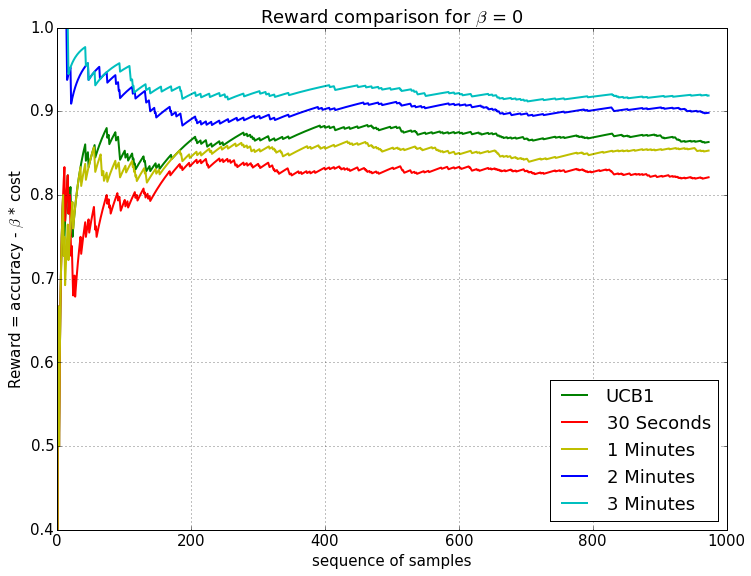

In [84]:
print len(ucb1_rewards)
print X_tests[0].shape[0]
plt.rcParams['figure.figsize'] = 12.0, 9.0
plt.rcParams.update({'font.size': 15})
xa = np.linspace(0, 973, num=973)
plt.plot(xa, ucb1_rewards, color='g', linewidth=2, label="UCB1")
plt.plot(xa, rewards_0, color='r', linewidth=2, label="30 Seconds")
plt.plot(xa, rewards_1, color='y', linewidth=2, label="1 Minutes")
plt.plot(xa, rewards_2, color='b', linewidth=2, label="2 Minutes")
plt.plot(xa, rewards_3, color='c', linewidth=2, label="3 Minutes")
plt.ylim([0.4,1])
plt.title("Reward comparison for $\\beta$ = 0")
plt.xlabel("sequence of samples")
plt.ylabel("Reward = accuracy - $\\beta$ * cost")
plt.grid()
plt.legend(loc=4)
plt.savefig('Rewards_beta_0.pdf')

## Plot the rewards for Context Based Bandit

973
973


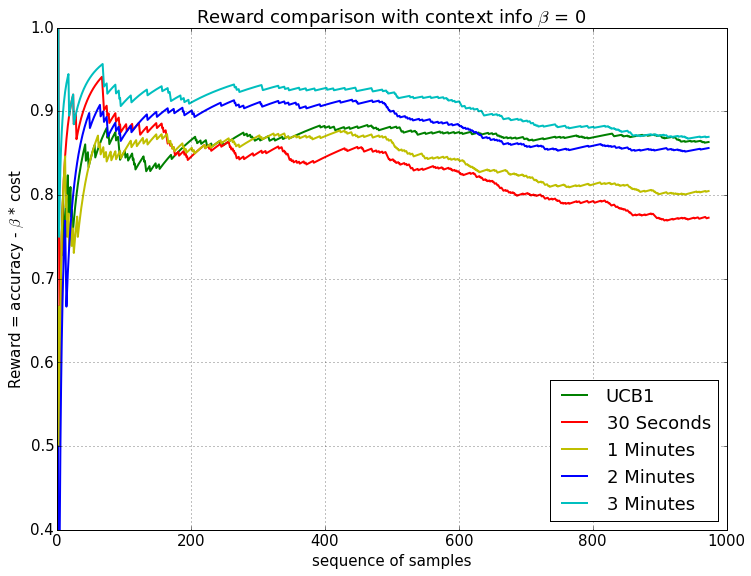

In [85]:
print len(rewards_0_c)
print X_tests[0].shape[0]
plt.rcParams['figure.figsize'] = 12.0, 9.0
plt.rcParams.update({'font.size': 15})
xa = np.linspace(0, 973, num=973)
plt.plot(xa, ucb1_rewards, color='g', linewidth=2.0, label="UCB1")
plt.plot(xa, rewards_0_c, color='r', linewidth=2.0, label="30 Seconds")
plt.plot(xa, rewards_1_c, color='y', linewidth=2.0, label="1 Minutes")
plt.plot(xa, rewards_2_c, color='b', linewidth=2.0, label="2 Minutes")
plt.plot(xa, rewards_3_c, color='c', linewidth=2.0, label="3 Minutes")
plt.ylim([0.4,1])
plt.title("Reward comparison with context info $\\beta$ = 0")
plt.xlabel("sequence of samples")
plt.ylabel("Reward = accuracy - $\\beta$ * cost")
plt.grid()
plt.legend(loc=4)
plt.savefig('Rewards_with_context_beta_0.pdf')

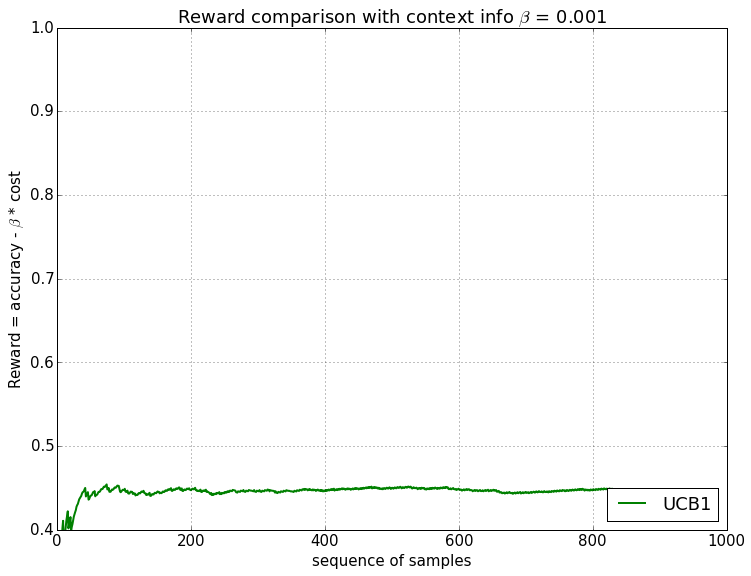

In [74]:
plt.rcParams['figure.figsize'] = 12.0, 9.0
plt.rcParams.update({'font.size': 15})
from scipy.interpolate import interp1d
xa = np.linspace(0, 973, num=973)
f = interp1d(xa, ucb1_rewards, kind='cubic')

plt.plot(xa, f(ucb1_rewards), color='g', linewidth=2.0, label="UCB1")
plt.ylim([0.4,1])
plt.title("Reward comparison with context info $\\beta$ = 0.001")
plt.xlabel("sequence of samples")
plt.ylabel("Reward = accuracy - $\\beta$ * cost")
plt.grid()
plt.legend(loc=4)
plt.savefig('Rewards_with_context_beta_0.001_interp.pdf')

In [66]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

t = np.arange(0.0, 1.0, 0.1)
s = np.sin(2*np.pi*t)
linestyles = ['_', '-', '--', ':']
markers = []
for m in Line2D.markers:
    try:
        if len(m) == 1 and m != ' ':
            markers.append(m)
    except TypeError:
        pass

styles = markers + [
    r'$\lambda$',
    r'$\bowtie$',
    r'$\circlearrowleft$',
    r'$\clubsuit$',
    r'$\checkmark$']

colors = ('b', 'g', 'r', 'c', 'm', 'y', 'k')

plt.figure(figsize=(8,8))

axisNum = 0
for row in range(6):
    for col in range(5):
        axisNum += 1
        ax = plt.subplot(6, 5, axisNum)
        color = colors[axisNum % len(colors)]
        if axisNum < len(linestyles):
            plt.plot(t, s, linestyles[axisNum], color=color, markersize=10)
        else:
            style = styles[(axisNum - len(linestyles)) % len(styles)]
            plt.plot(t, s, linestyle='None', marker=style, color=color, markersize=10)
        ax.set_yticklabels([])
        ax.set_xticklabels([])

plt.show()

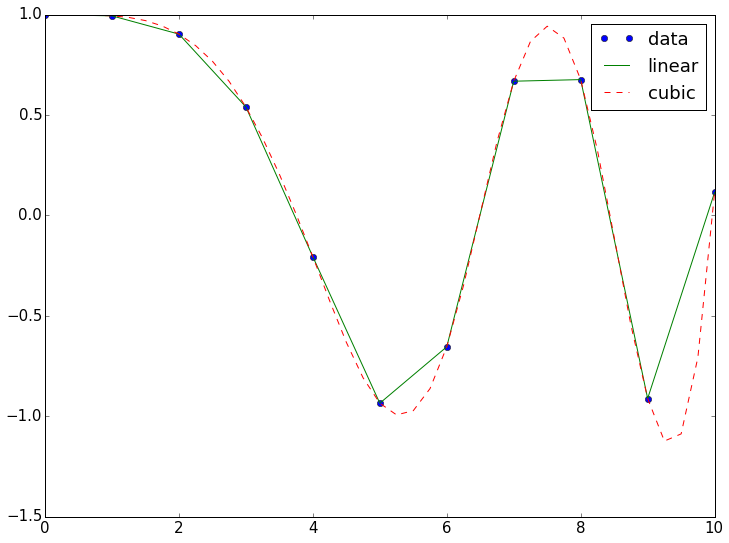

In [48]:
from scipy.interpolate import interp1d
x = np.linspace(0, 10, num=11, endpoint=True)
y = np.cos(-x**2/9.0)
f = interp1d(x, y)
f2 = interp1d(x, y, kind='cubic')
xnew = np.linspace(0, 10, num=41, endpoint=True)
import matplotlib.pyplot as plt
plt.plot(x, y, 'o', xnew, f(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()

# 2. Contextual Bandit Learning

## Todos
2. Partition the training and testing samples based on file size (context)
3. Train all classifiers for different context

## Meeting Notes on August 18th

1. evolution of the optimal classifier for each context space.
2. regret for ucb and context based MAB
3. different update span, another possible optimization 
4. different context space may reach to different 
5. performance evaluation. complexity, cost
6. benchmark 
  1. compare to classic ML (using all testing data)
  2. random choose classifier. compare
7. multiple random sequence arrival, get the expectation.
8. Deep learning as the 

Transaction on system man, and cybernetics: systems
Forencis and security
Trans on dependable and secure computing. malware dectection in cloud computing infrastructure.

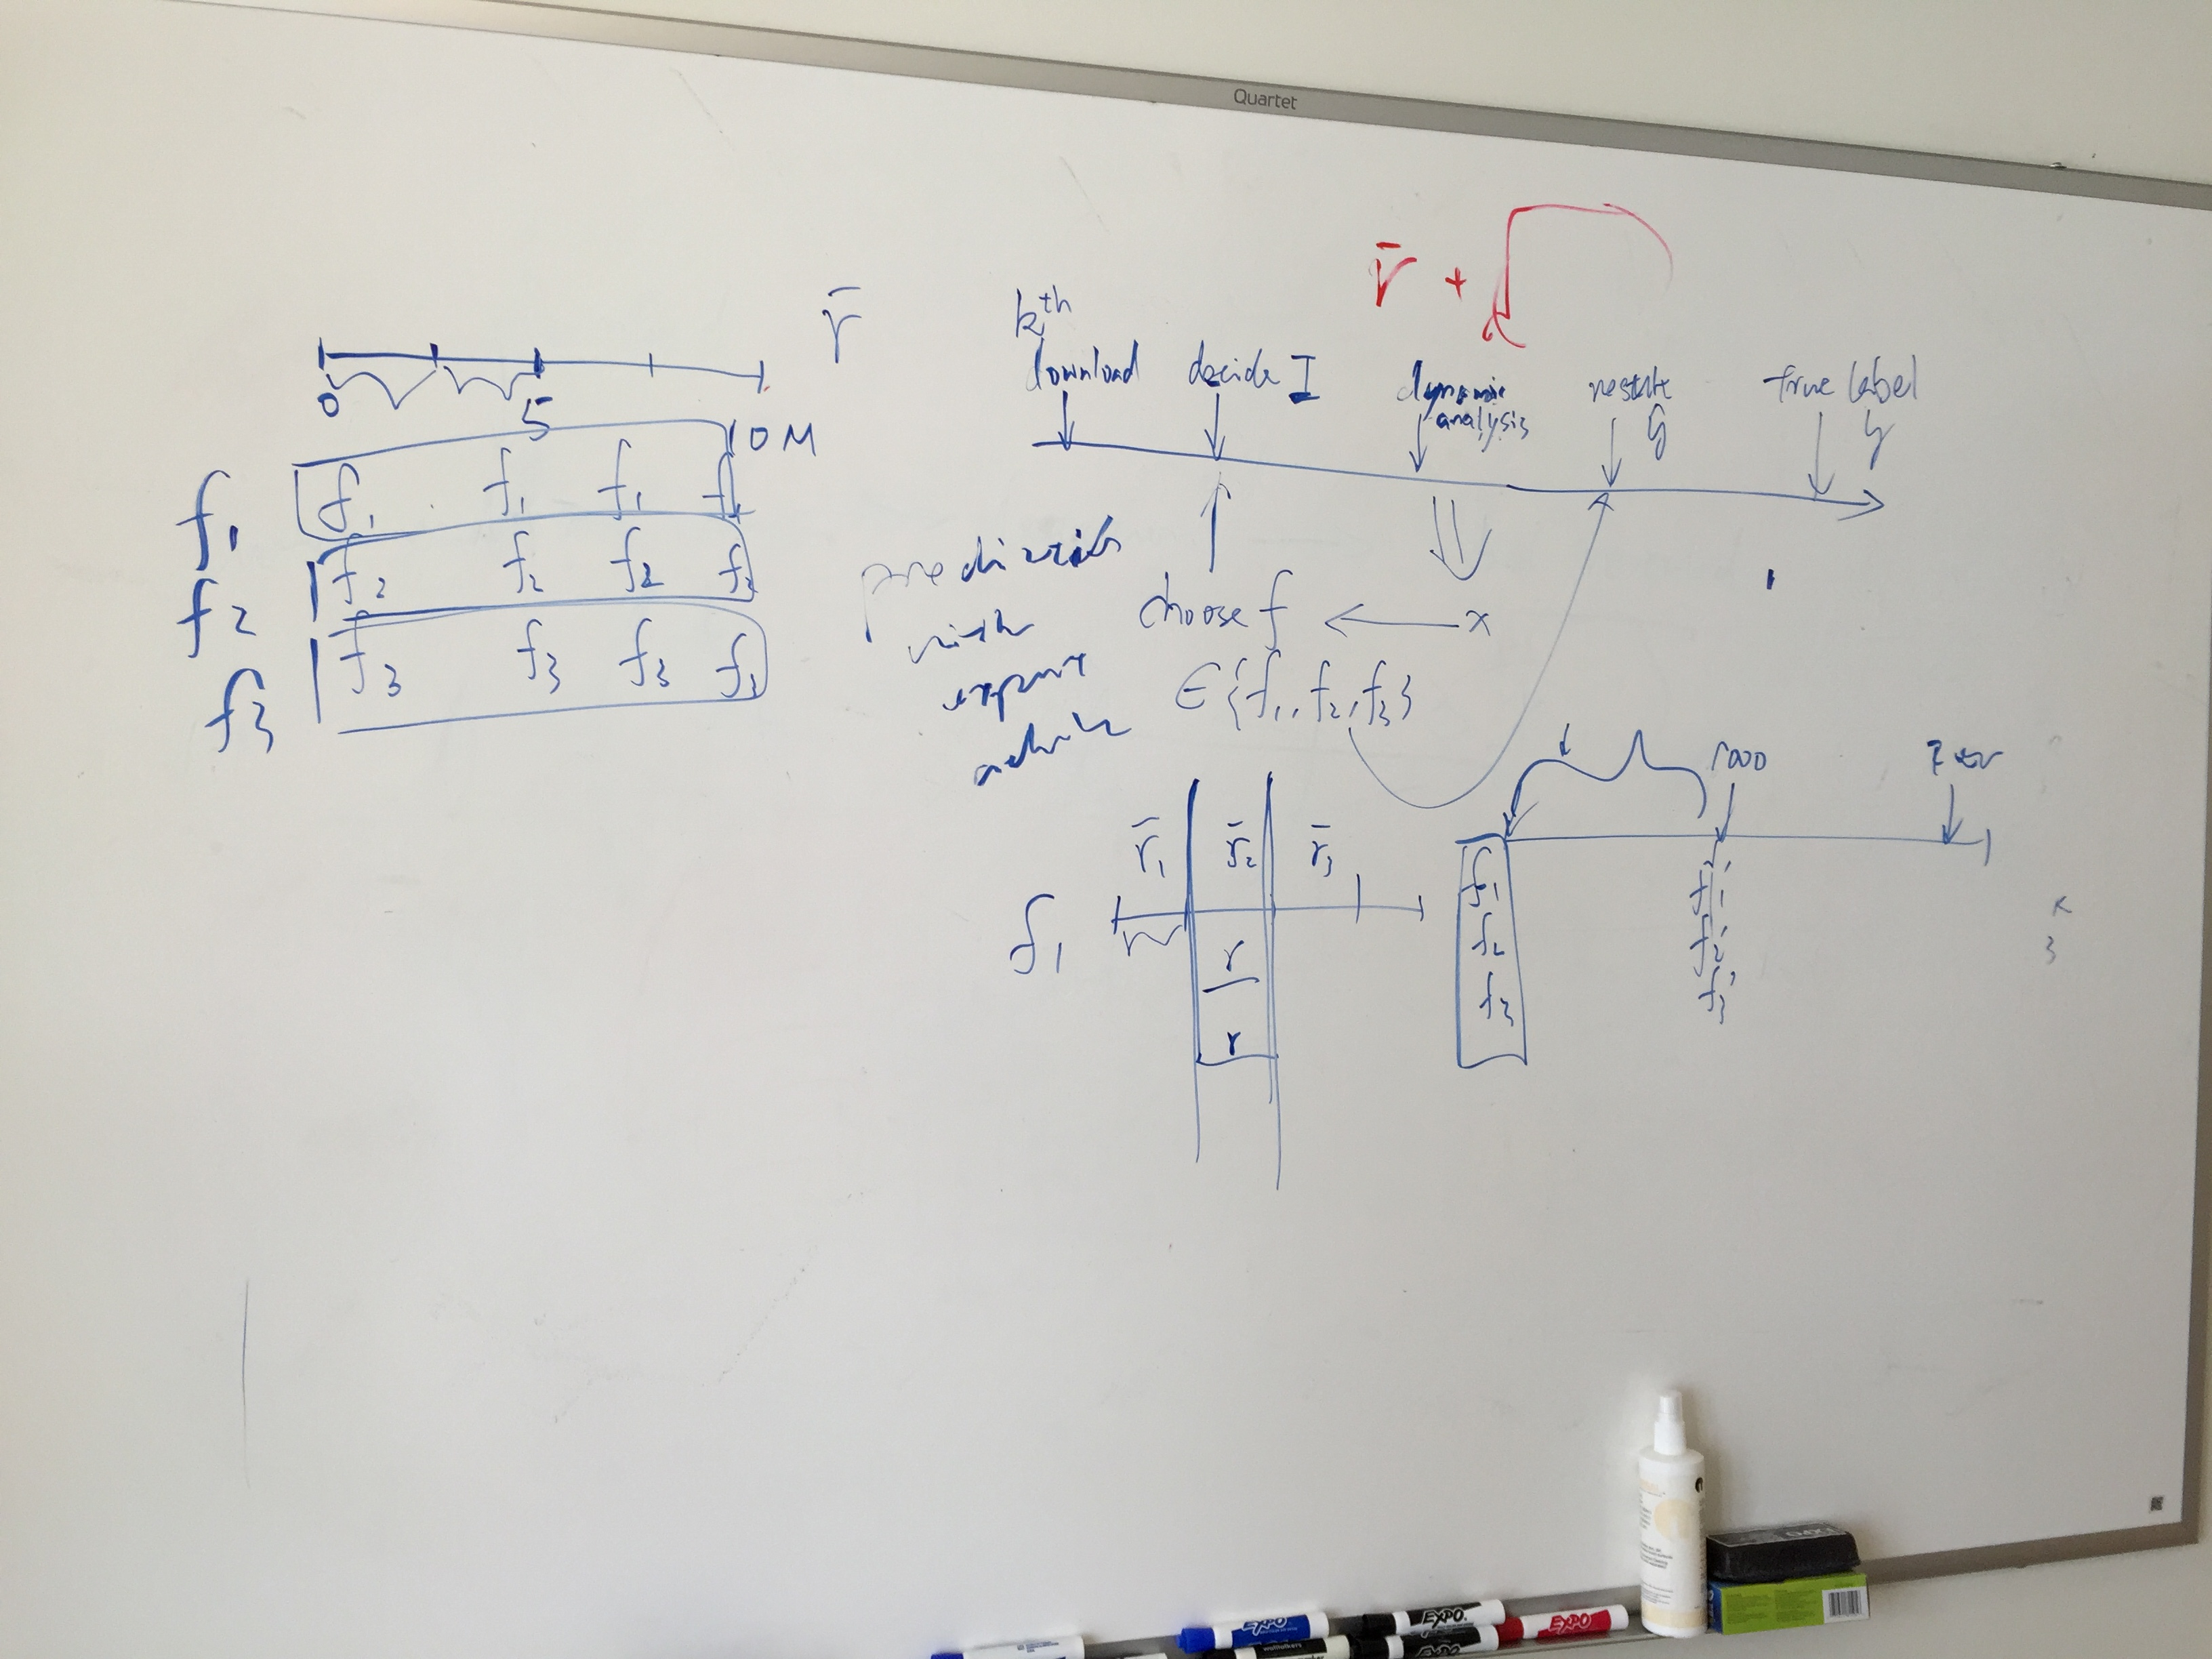

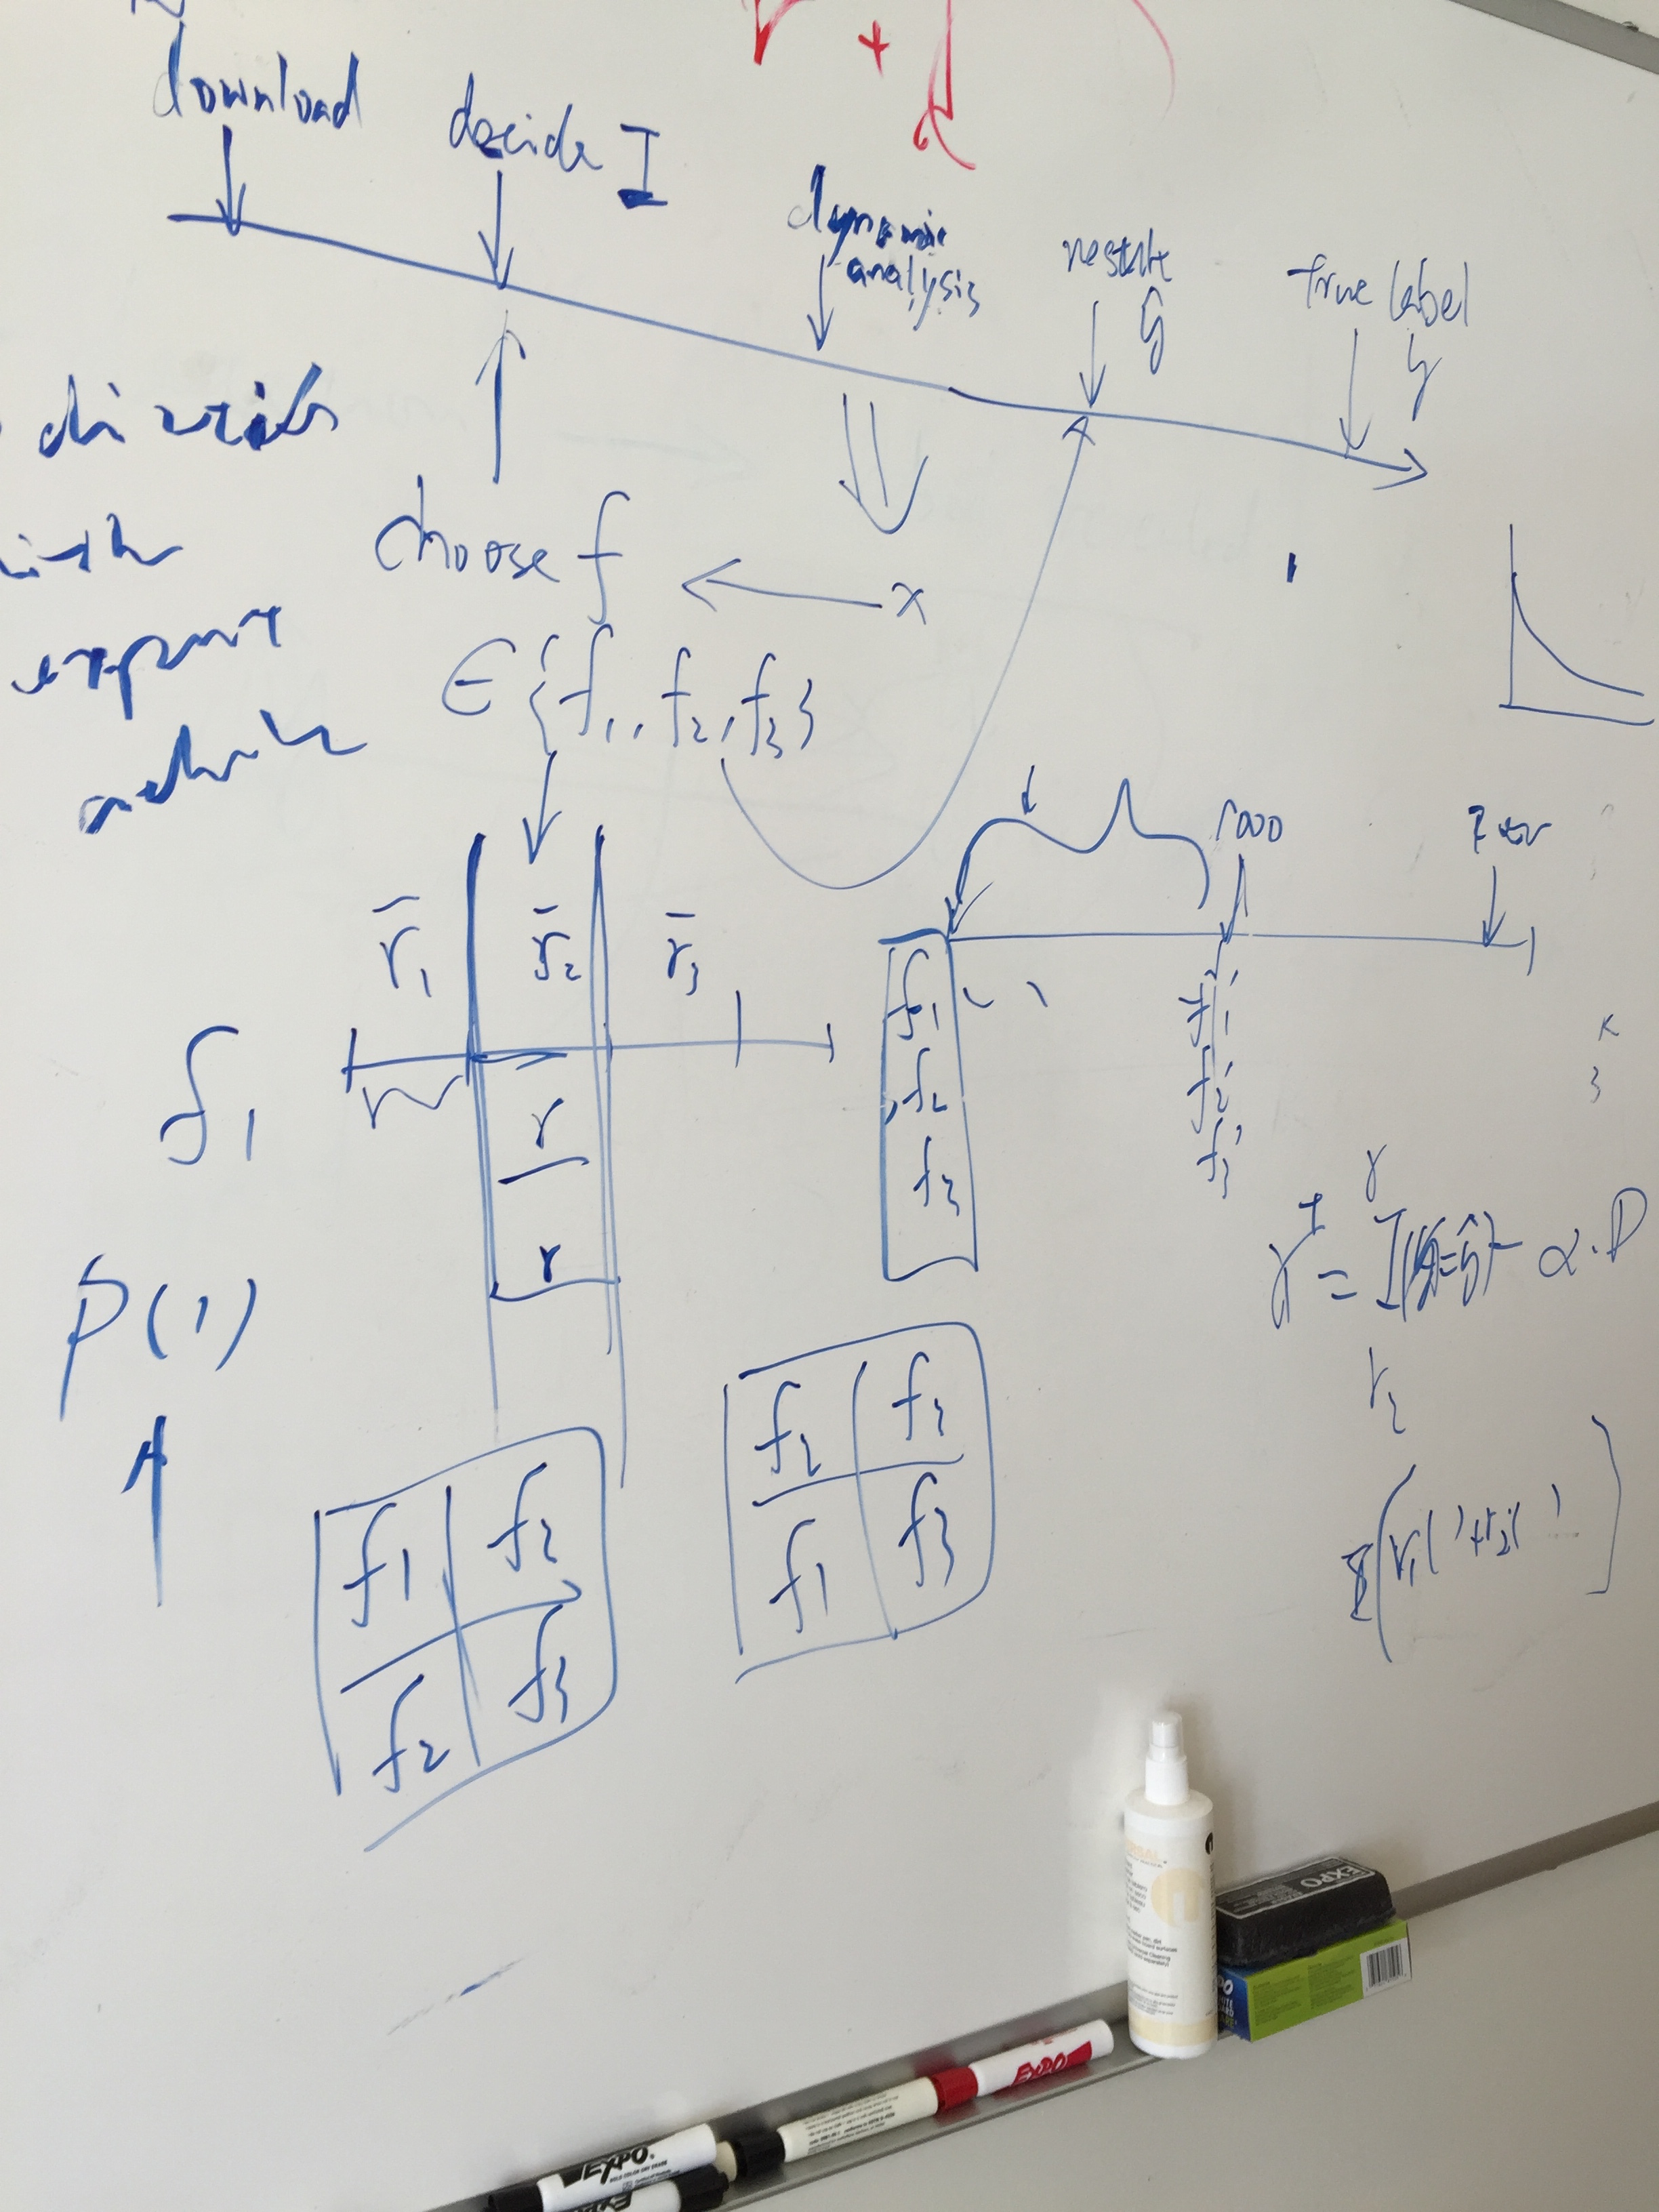

In [67]:
from IPython.core.display import Image, display
display(Image(filename='Discussion_Xu_1.jpeg'))
display(Image(filename='Discussion_Xu_2.jpeg'))

## Defind ```class Execution_status``` to retrive info

Some of the files are not executed normally. We want to find out such abnormal examples. and do various of analysis on both the bad and good examples.

In [68]:
class Execution_status:
    """Utility class that retrive various informations about the executions"""
    
    def __init__(self, file_list, db):
        self.filelist = file_list
        self.db = db
        self.total = 0
        self.duration_hash = [] 
        self.duration_size = []
        self.fsize_hash = []
        self.durations = defaultdict(list) # {1: ["hash1", "hash2, ...], 2: ["hash5","hash6", ...], ...}
        self.fsizes = defaultdict(list)
        self.failed = []     # list of files failed execution (not in mongodb)
     
    def retrive_status(self):
        for filepath in self.filelist:
        # get the sha256 in case the file name isn't
            path, hash_name = os.path.split(filepath)
            if len(hash_name) != 64:
                hash_name = get_sha256(filepath)

            report = self.db.find_one({"target.file.sha256" : hash_name})
            if report:
                if "duration" in report["info"] and "file" in report["target"] and "size" in report["target"]["file"]:
                    duration = report["info"]["duration"]
                    size = report["target"]["file"]["size"]
                    self.duration_hash.append([int(duration), hash_name])
                    self.duration_size.append([int(duration), int(size)])
                    self.fsize_hash.append([int(size), hash_name])
                    self.total += 1
            else:
                self.failed.append(hash_name)
                
        for k, v in self.duration_hash:
            self.durations[k].append(v)   
        for m, n in self.fsize_hash:
            self.fsizes[m].append(n)
            
    def get_n_samples(self):
        """return the total numbe or samples that retrived success from db"""
        return self.total
    
    def get_failed(self):
        """return a list of failed file hash"""
        return self.failed
        
    def get_fsize_hash(self):
        return self.fsize_hash
    
    def get_duration_size(self):
        """For scatter plot duration and file size"""
        return self.duration_size

    def get_duration_eq(self, sec):
        """Return all the file hash that execute "sec" second"""
        return self.durations[sec]
    
    def get_size_lt(self, b):
        """Get all the file hash with its size lt 'b' """ 
        res = []
        for k in self.fsizes:
            if k < b:
                res.extend(self.fsizes[k])
        
        return res
    
    def get_duration_lt(self, sec):
        """get all hash with timeout less than sec exclusively"""
        res = []
        for k in self.durations:
            if k < sec:
                res.extend(self.durations[k]) 
                
        return res
    
    def get_size_gt(self, b):
        """get all the file hash with its size gt 'b' """
        res = []
        for k in self.fsizes:
            if k >= b:
                res.extend(self.fsizes[k])
                
        return res
    
    def get_duration_gt(self, sec):
        """get all hash with timeout greater than sec inclusively"""
        res = []
        for k in self.durations:
            if k >= sec:
                res.extend(self.durations[k])
                
        return res
    
    def get_duration_all(self):
        """get a dictionary, key:duration, value: list_of_files"""
        
        return self.durations
    
    def get_duration_sum(self):
        """get the sum of duration of all executed samples"""
        duration = [n[0] for n in self.duration_hash]
        
        return sum(duration)

## Function that divide samples into context spaces.
* input: file_list, db0m
* output: list of lists that each inner list includes the hash of file belong to that context.

In [46]:
def get_context_file_lists(all_files, db):
    """this function take the directory file name and the database as input
       it returns the grouped sample indexes in lists, each of which indicate
       a context """

## Take a look at the data
We want to find how many context we should keep?

In [124]:
def distribution_by_fsize(good_status, bad_status):

    # calculate the number of quantums for each size range 
    #all_size_quantums = np.concatenate((np.arange(1024,1024*1024+1,1024), np.arange(1024*1024+1,60*1024*1024+1,1024*1024*10)), axis=0)
    all_size_quantums = np.concatenate((np.arange(1024*10,1024*1024+1,1024*10), np.arange(1024*1024+1,60*1024*1024+1,1024*1024*10)), axis=0)
    #all_size_quantums = np.arange(1024*1024, 60*1024*1024+1, 1024*1024)

    good_quantums = []#{100: [hash1, hash2, ...], 200: [...]}
    bad_quantums = []
    for gap in all_size_quantums:
        good_quantums.append(good_status.get_size_lt(gap))
        bad_quantums.append(bad_status.get_size_lt(gap))

    g_prev_counts = 0
    b_prev_counts = 0
    good_counts = []
    bad_counts = []
    for g, b in zip(good_quantums, bad_quantums):
        good_counts.append(len(g) - g_prev_counts) 
        bad_counts.append(len(b) - b_prev_counts) 
        g_prev_counts = len(g)
        b_prev_counts = len(b)

    # start plot the bar chart
    n_groups = len(all_size_quantums)

    plt.subplots(figsize=(16,5))
    #fig, ax = plt.subplots()

    index = np.arange(n_groups)
    bar_width = 0.15

    opacity = 0.4
    error_config = {'ecolor': '0.3'}

    #plt.rcParams['font.size'] = 10.0
    #plt.rcParams['figure.figsize'] = 16.0, 5.0
    for a, b in zip(enumerate(good_counts, 1), enumerate(bad_counts, 1)):
        print "{0}0kB, {1}, {2}".format(a[0], a[1], b[1])
    #for i, a in enumerate(good_counts, 1):
    #    print "{0}0kB: {1}".format(i, a)
    #print "===================================================================================================="
    #for i, b in enumerate(bad_counts, 1):
    #    print "{0}0kB: {1}".format(i, b)
    rects1 = plt.bar(index, good_counts, bar_width,
                     alpha=opacity,
                     color='b',
                     #yerr=std_men,
                     error_kw=error_config,
                     label='good')

    rects2 = plt.bar(index + bar_width, bad_counts, bar_width,
                     alpha=opacity,
                     color='r',
                     #yerr=std_women,
                     error_kw=error_config,
                     label='bad')

    plt.xlabel('Duration Quantums (second)')
    plt.ylabel('Number of Samples')
    plt.title('Real Timeout Distribution')
    plt.xticks(index + bar_width, all_size_quantums, rotation=20)
    plt.legend()

In [125]:
good_status_3 = Execution_status(good_file_list, db3m)
good_status_3.retrive_status()

bad_status_3 = Execution_status(bad_file_list, db3m)
bad_status_3.retrive_status()

## How to divide the contextual space
* fix the number of samples should fall into each space. (for good and bad)
* merge each subspace for good and bad together to form the training dataset for contextual classifiers.
* should make sure the training data and test data:
  1. quantums should evenly presented in the training and testing data
  2. in each quantums, good and bad should be straitified
  
  
Meeting:
1. use clustering algorithms to divide subspace.
2. epsilon.
2. Tompson sampling.

In [126]:
a = np.arange(1, 11)
b = np.arange(2, 21, 2)
for a, b in zip(enumerate(a, 1), enumerate(b, 1)):
    print a[0], a[1], b[0], b[1]

1 1 1 2
2 2 2 4
3 3 3 6
4 4 4 8
5 5 5 10
6 6 6 12
7 7 7 14
8 8 8 16
9 9 9 18
10 10 10 20


10kB, 0, 9
20kB, 0, 22
30kB, 0, 47
40kB, 1, 44
50kB, 2, 38
60kB, 0, 17
70kB, 1, 36
80kB, 0, 40
90kB, 2, 28
100kB, 1, 28
110kB, 0, 32
120kB, 0, 31
130kB, 4, 17
140kB, 2, 17
150kB, 1, 19
160kB, 2, 14
170kB, 1, 22
180kB, 1, 14
190kB, 0, 16
200kB, 0, 15
210kB, 0, 15
220kB, 0, 15
230kB, 0, 27
240kB, 0, 10
250kB, 0, 32
260kB, 0, 47
270kB, 1, 7
280kB, 1, 10
290kB, 1, 8
300kB, 0, 38
310kB, 0, 16
320kB, 4, 8
330kB, 0, 19
340kB, 2, 3
350kB, 0, 13
360kB, 0, 9
370kB, 0, 20
380kB, 2, 42
390kB, 1, 3
400kB, 2, 4
410kB, 2, 26
420kB, 5, 6
430kB, 1, 6
440kB, 1, 13
450kB, 1, 4
460kB, 0, 3
470kB, 0, 3
480kB, 0, 1
490kB, 1, 4
500kB, 2, 3
510kB, 3, 1
520kB, 2, 1
530kB, 2, 1
540kB, 1, 33
550kB, 2, 5
560kB, 0, 24
570kB, 0, 8
580kB, 1, 3
590kB, 0, 3
600kB, 0, 2
610kB, 2, 24
620kB, 1, 4
630kB, 1, 4
640kB, 0, 2
650kB, 0, 3
660kB, 0, 23
670kB, 4, 9
680kB, 3, 3
690kB, 0, 5
700kB, 5, 4
710kB, 5, 1
720kB, 2, 5
730kB, 2, 6
740kB, 3, 5
750kB, 3, 2
760kB, 0, 3
770kB, 2, 0
780kB, 4, 0
790kB, 4, 2
800kB, 3, 1
810kB, 3, 2

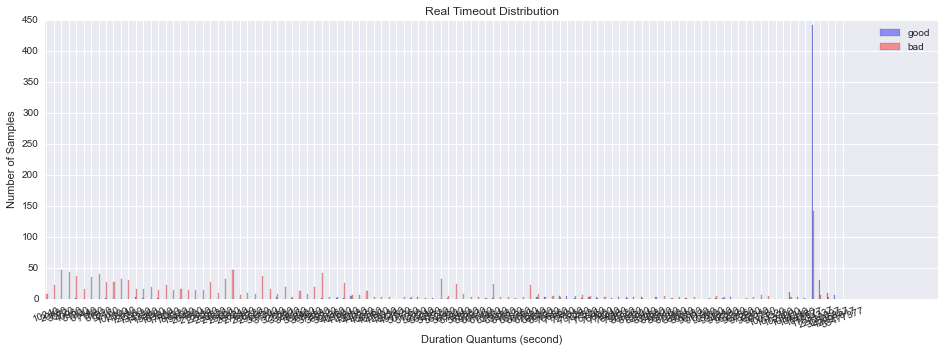

In [127]:
distribution_by_fsize(good_status_3, bad_status_3)

## Get the list of sample sorted by file size

In [35]:
def get_file_list_by_size(dirname, reverse=False):
    """ Return list of file paths in directory sorted by file size """

    # Get list of files
    filepaths = []
    for basename in os.listdir(dirname):
        filename = os.path.join(dirname, basename)
        if os.path.isfile(filename):
            filepaths.append(filename)

    # Re-populate list with filename, size tuples
    for i in xrange(len(filepaths)):
        filepaths[i] = (filepaths[i], os.path.getsize(filepaths[i]))

    # Sort list by file size
    # If reverse=True sort from largest to smallest
    # If reverse=False sort from smallest to largest
    filepaths.sort(key=lambda filename: filename[1], reverse=reverse)

    # Re-populate list with just filenames
    for i in xrange(len(filepaths)):
        filepaths[i] = filepaths[i][0]
        

    return filepaths

start = time()
badDataPath = "/Volumes/SST3/Samples/ml_test_set_all_1315/"
#bad_file_list = [os.path.join(badDataPath, child) for child in os.listdir(badDataPath)]
bad_file_list = [child for child in get_file_list_by_size(badDataPath) if child.find('._') == -1]
#df_bad_0 = load_dataframe(bad_file_list, 'bad', db0m, "0")
#df_bad_0.to_csv('df_bad_DataFrameRaw_0.csv', index=False)

goodDataPath = "/Volumes/SST3/Samples/gd_test_set_all_630/"
#good_file_list = [os.path.join(goodDataPath, child) for child in os.listdir(goodDataPath) if child.find('._')]
good_file_list = [child for child in get_file_list_by_size(goodDataPath) if child.find('._') == -1]
#df_good_0 = load_dataframe(good_file_list, 'good', db0m, "0")
#df_good_0.to_csv('df_good_DataFrameRaw_0.csv', index=False)
end = time()

In [36]:
good_file_list
len(good_file_list)
bad_file_list

['/Volumes/SST3/Samples/ml_test_set_all_1315/e12055d0e8f166b0b3140677c0091db947553f25fcb1b2eb4914d7103cb2830e',
 '/Volumes/SST3/Samples/ml_test_set_all_1315/d823035ba2eca3de6ef191da40142effd6f46a413e036437cdc49e6a5c51c840',
 '/Volumes/SST3/Samples/ml_test_set_all_1315/f24da4e3eb55bb1dccd8840534f98902c51db9a0027e41d769e636412cfad362',
 '/Volumes/SST3/Samples/ml_test_set_all_1315/07424874f9b2d8ada684d3780781e5ee8667a283f9ae794849748d1c03447f36',
 '/Volumes/SST3/Samples/ml_test_set_all_1315/cd7aedd3a3fab0e687ad899af07daca31d4ae99413ff278ee465d2fd2737b099',
 '/Volumes/SST3/Samples/ml_test_set_all_1315/7ea59683dcae296bf95278b197631a339624f565492cb7aed32c740b6b4053e8',
 '/Volumes/SST3/Samples/ml_test_set_all_1315/003fa2b8d2cabdb646494aa6079fe4f3a40935525598c44750253bd77bc05cfd',
 '/Volumes/SST3/Samples/ml_test_set_all_1315/367e9c0373442ce02ab4a6738dab40a1ba4399a90253f8f84e1cf9f52bbce896',
 '/Volumes/SST3/Samples/ml_test_set_all_1315/77d9de8e0640f49cec91f8ec0ad81ec651662de193737648e19858c32b1

## Retrive the sample information from DB

In [53]:
good_status_3 = Execution_status(good_file_list, db3m)
good_status_3.retrive_status()

bad_status_3 = Execution_status(bad_file_list, db3m)
bad_status_3.retrive_status()

# ========================Example Code=========================
## Check the total time the good samples and bad samples run

In [44]:
good_total = good_status.get_duration_sum()
bad_total = bad_status.get_duration_sum()
print "good total time = %.2f Hours" % (float(good_total)/3600)
print "bad total time  = %.2f Hours" % (float(bad_total)/3600)
#print "Paralell total  = %.2f Hours" % (((float(good_total)/3600) + (float(bad_total)/3600)) / 2)
print "Good Average    = %.2f Seconds" % (float(good_total)/good_status.get_n_samples())
print "Bad Average     = %.2f Seconds" % (float(bad_total)/bad_status.get_n_samples())

good total time = 13.01 Hours
bad total time  = 18.37 Hours
Good Average    = 74.36 Seconds
Bad Average     = 50.30 Seconds


## Check if sample not executed

In [45]:
good_failed = good_status.get_failed()
print "( %d )Good failed:" % len(good_failed)
for n in good_failed:
    print n
    
bad_failed = bad_status.get_failed()
print "( %d )Bad failed:" % len(bad_failed)
for n in bad_failed:
    print n

( 0 )Good failed:
( 0 )Bad failed:


## Plot the scattered dots file size V.S. "duration"

4 duration about 800 seconds: ['02620952785068d8e5e42dfe4b839c3789d8352969191b1723fd9b6a35881571', '0ae615c5f0ae325cc6a0d0eda2ebfb12bf44fca84f06aa2fa49fa115cd614c33', 'c563ec8beae2eebff2c2cfc86e5e4d2a45226c0976d0a7336de1885f5e3804f0', '6230d9e552e69823b83d6f81a5dadc06958d7a17e10c3f8e525fcc61b300b2ef']


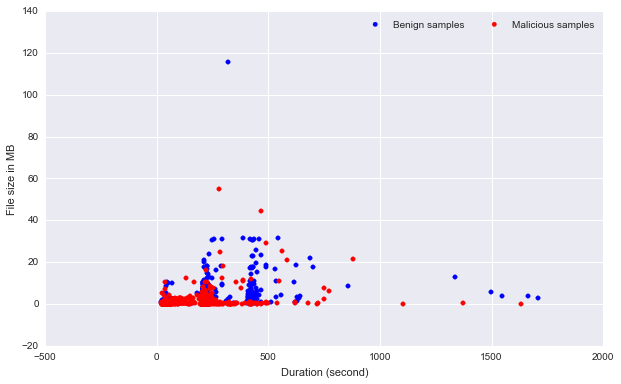

In [53]:
plt.subplots(figsize=(10,6))
good_duration_size = good_status_3.get_duration_size()
good_duration = [n[0] for n in good_duration_size]
good_size = [float(n[1])/1024/1024 for n in good_duration_size]
goodot = plt.scatter(good_duration, good_size, color='b', label="Benign samples")

bad_duration_size = bad_status_3.get_duration_size()
bad_duration = [n[0] for n in bad_duration_size]
bad_size = [float(n[1])/1024/1024 for n in bad_duration_size]
badot = plt.scatter(bad_duration, bad_size, color='r', label="Malicious samples")
plt.xlabel("Duration (second)")
plt.ylabel("File size in MB")
plt.legend((goodot, badot),
           ('Benign samples', 'Malicious samples'),
           scatterpoints=1,
           loc='upper right',
           ncol=3)
#plt.ylim(-5,40)
#plt.savefig('a.pdf')
#subprocess.call(["pdfcrop", "a.pdf", "a.pdf"])
duration_800 = bad_status_3.get_duration_gt(800)
print "%d duration about 800 seconds: %s" % (len(duration_800), duration_800)

## Bar chart of successfully executed samples

1. x axis: 10, 20, 30
2. y axis: # of samples fall in between neighboring durations

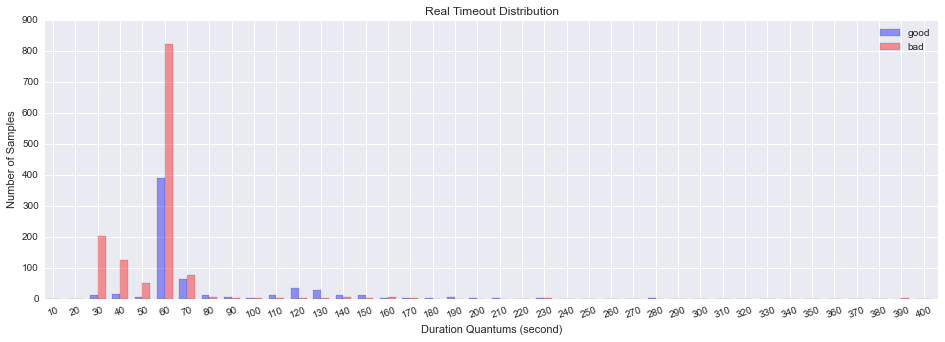

In [48]:
# calculate the number of quantums 
all_durations = np.arange(10, 401, 10)

good_quantums = []#{10: [hash1, hash2, ...], 20: [...]}
bad_quantums = []
for gap in all_durations:
    good_quantums.append(good_status.get_duration_lt(gap))
    bad_quantums.append(bad_status.get_duration_lt(gap))

g_prev_counts = 0
b_prev_counts = 0
good_counts = []
bad_counts = []
for g, b in zip(good_quantums, bad_quantums):    
    good_counts.append(len(g) - g_prev_counts) 
    bad_counts.append(len(b) - b_prev_counts) 
    g_prev_counts = len(g)
    b_prev_counts = len(b)

# start plot the bar chart
n_groups = len(all_durations)

plt.subplots(figsize=(16,5))
#fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

#plt.rcParams['font.size'] = 10.0
#plt.rcParams['figure.figsize'] = 16.0, 5.0

rects1 = plt.bar(index, good_counts, bar_width,
                 alpha=opacity,
                 color='b',
                 #yerr=std_men,
                 error_kw=error_config,
                 label='good')

rects2 = plt.bar(index + bar_width, bad_counts, bar_width,
                 alpha=opacity,
                 color='r',
                 #yerr=std_women,
                 error_kw=error_config,
                 label='bad')

plt.xlabel('Duration Quantums (second)')
plt.ylabel('Number of Samples')
plt.title('Real Timeout Distribution')
plt.xticks(index + bar_width, np.arange(10,410,10), rotation=20)
plt.legend()